## Setup, Loading Data and CDFs

In [10]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [11]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_full_agriVision.ipynb


In [12]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)
assert CWD == os.getcwd()

Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/diagonal/gray'

In [13]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [14]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [15]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4500,
 3: 18000,
 4: 72000,
 5: 288000,
 6: 1152000,
 7: 4608000,
 8: 18432000,
 9: 73728000,
 10: 294912000}

Running 12721 CDFs


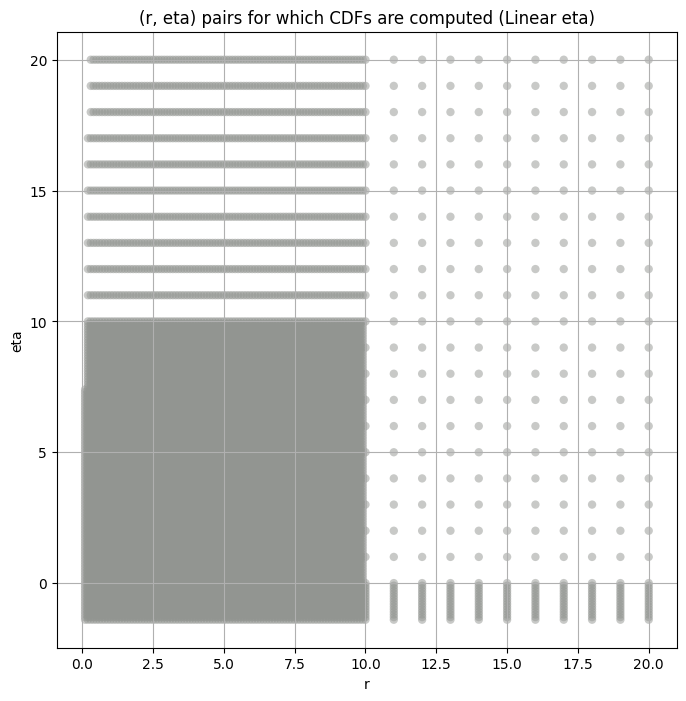

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [16]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df[~all_cdfs_df['kurtosis'].isna()]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);

all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [17]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [18]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    #master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

#master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df


Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      49450.980469  19202.867188  101513.000000   500.580811   93.005814   
3       8568.368164   4678.516113   14358.226562   487.672516  163.083923   
4       1787.585205    838.502747    3350.636475   762.550354  170.148346   
5        284.274750    138.199066     671.343445  1228.929688   86.793030   
6         70.411041     35.697952     185.533096  1638.797119   65.571648   
7         23.222046     12.280906      72.200691  2538.970459   51.936737   
8          9.512077      4.864893      27.376392  1990.125610   68.890762   
9          1.696372      0.967391       4.156639  1298.781494   67.881310   
10         0.181317      0.080193       0.812861  5574.856445   78.470016   

        kurt_upper  total_samples  
layer                              
2       851.761047           4500  
3       789.382874          18000  
4      1375.016479          72000  
5      3410.601807         288000  
6      3892.750488        1152000  
7      4483.448242        4608000  
8      4263.745605       18432000  
9      3193.164795       73728000  
10     6336.022949      294912000

## Initial Grid Search and Hypothesis Test Plots

In [19]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [20]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      49450.980000   49450.980469     8567.621094     6782.843750   
3       8568.368000    8568.368164     2502.127197     2043.140503   
4       1787.585200    1787.585205      768.700623      597.265198   
5        284.274750     284.274750      142.886078      120.357635   
6         70.411040      70.411041       37.032257       31.964481   
7         23.222046      23.222046       12.749860       11.209029   
8          9.512077       9.512077        5.095488        4.380235   
9          1.696372       1.696372        1.015996        0.874835   
10         0.181317       0.181317        0.084603        0.071797   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5650.314453      4890.156738      3824.677734      3097.633545   
3         1782.679199      1609.879761      1375.509644      1209.377686   
4          519.176636       472.828125       415.471863       376.292114   
5          108.626266       100.498528        89.893845        82.792633   
6           29.212294        27.365221        24.979393        23.380512   
7           10.349060         9.771373         8.996522         8.475763   
8            3.985188         3.723282         3.387993         3.173325   
9            0.795762         0.743650         0.676435         0.631940   
10           0.064816         0.060294         0.054487         0.050626   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2562.221924      2154.326172      1823.494629      1179.780518  
3          1082.169312       982.348022       899.215149       716.533875  
4           348.439117       326.577698       308.454254       267.895630  
5            77.559807        73.374283        69.955170        62.174274  
6            22.181648        21.229595        20.438040        18.658548  
7             8.088338         7.779855         7.524806         6.943770  
8             3.016775         2.893043         2.789802         2.552030  
9             0.598457         0.571386         0.548558         0.495570  
10            0.047699         0.045323         0.043313         0.038628

####
Layer  2


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 0 0.012977025542726617 49450.98


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 25 0.015869048634541916 8567.621


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 50 0.014514224847522739 6782.8438


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 75 0.02314136732763472 5650.3145


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 100 0.014417312656724302 4890.1567


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 150 0.012757926760497251 3824.6777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 200 0.01652389509274954 3097.6335


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 250 0.016894221863185233 2562.222


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 300 0.019557741078915766 2154.3262


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 350 0.02716703185965169 1823.4946


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 500 0.5026666666666667 1179.7805
Number of samples: 4500, Without approximation : 4500


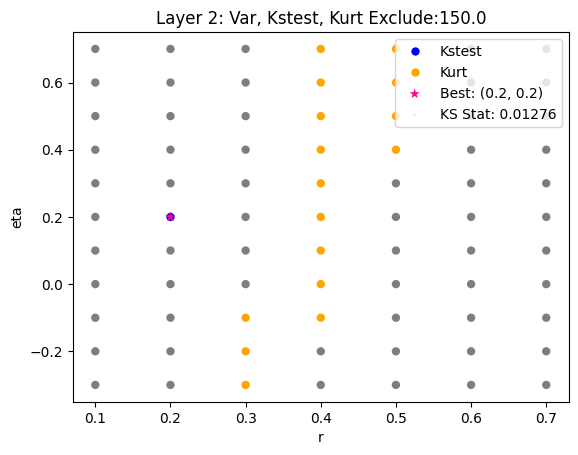

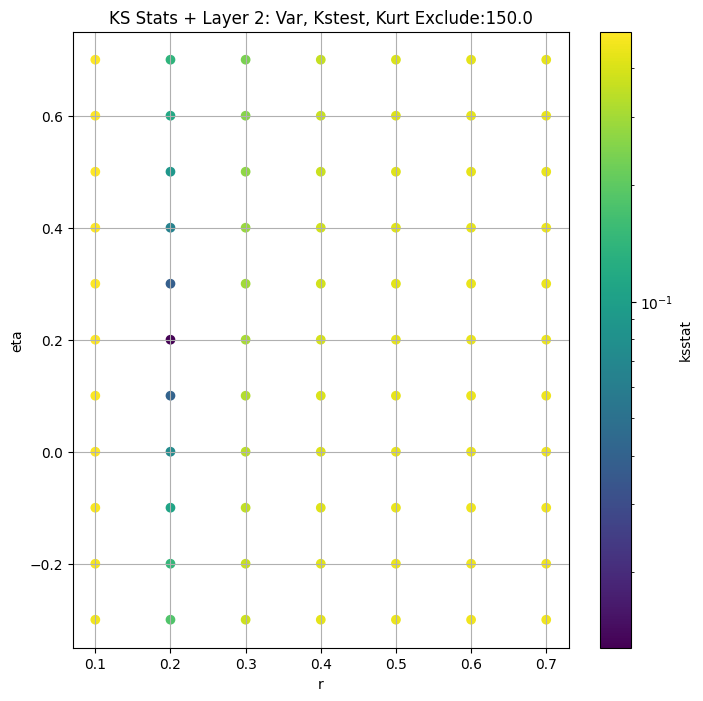

####
Layer  3


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 0 0.017255535776846798 8568.368


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 25 0.020902786009732055 2502.1272


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 50 0.021173223174878575 2043.1405


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 75 0.02415375588518287 1782.6792


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 100 0.023652149068787987 1609.8798


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 150 0.02384111432425795 1375.5096


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 200 0.02639876786529538 1209.3777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 250 0.02619445307157864 1082.1693


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 300 0.027652648879506803 982.348


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 350 0.02005461083918736 899.21515


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 500 0.030642798463618615 716.5339
Number of samples: 18000, Without approximation : 18000


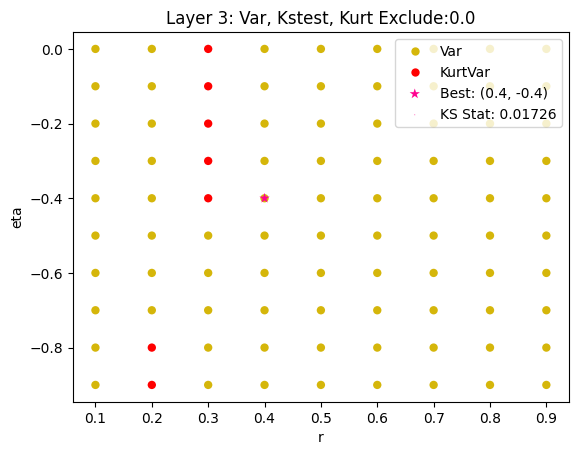

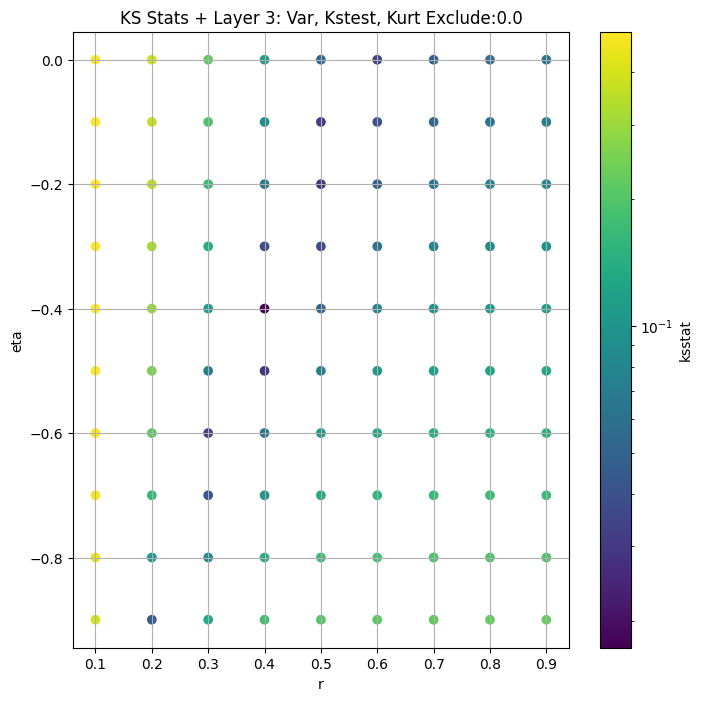

####
Layer  4


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 0 0.014807857157649235 1787.5852


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 25 0.01664999636607853 768.7006


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 50 0.018093290470257872 597.2652


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 75 0.017777282094361246 519.17664


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 100 0.019523404994360005 472.82812


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 150 0.013872954004380711 415.47186


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 200 0.017042434858023814 376.2921


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 250 0.01255993523172727 348.43912


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 300 0.020014044341778336 326.5777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 350 0.011473148978211195 308.45425


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 500 0.016796850921818013 267.89563
Number of samples: 72000, Without approximation : 72000


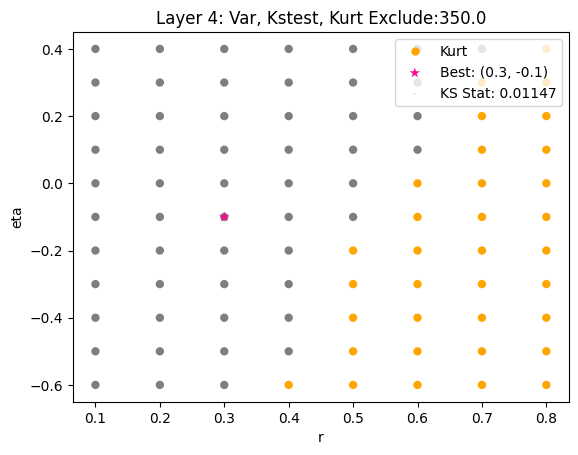

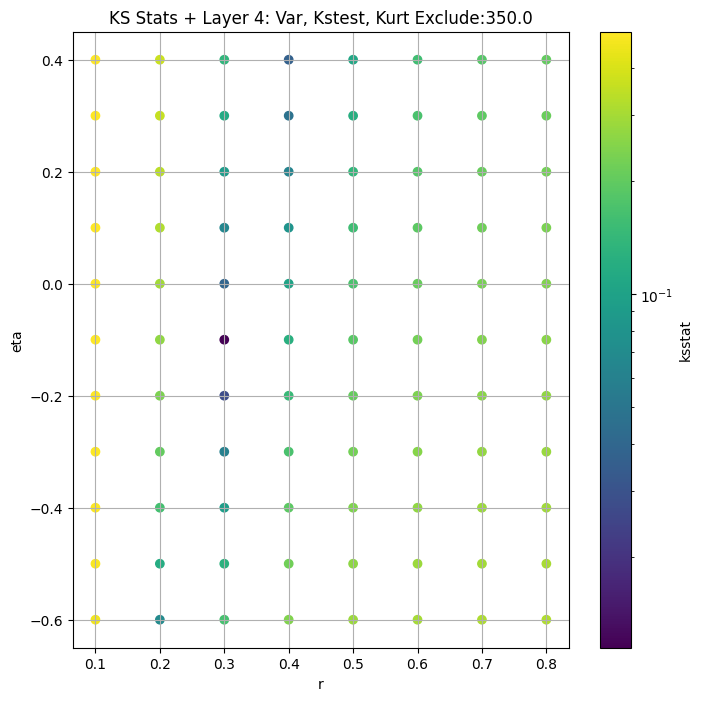

####
Layer  5


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 0 0.030592387911566266 284.27475


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 25 0.013416022588133347 142.88608


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 50 0.012294345879379462 120.357635


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 75 0.012562527493145348 108.62627


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 100 0.012313716050613488 100.49853


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 150 0.013167871756380123 89.893845


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 200 0.008072466081287977 82.79263


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 250 0.011508223734309486 77.55981


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 300 0.009670206095972578 73.37428


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 350 0.01094491342367876 69.95517


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 500 0.009872149088297921 62.174274
Number of samples: 100000, Without approximation : 288000


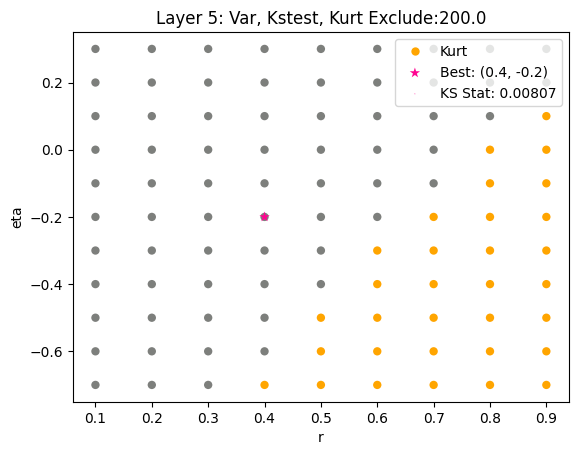

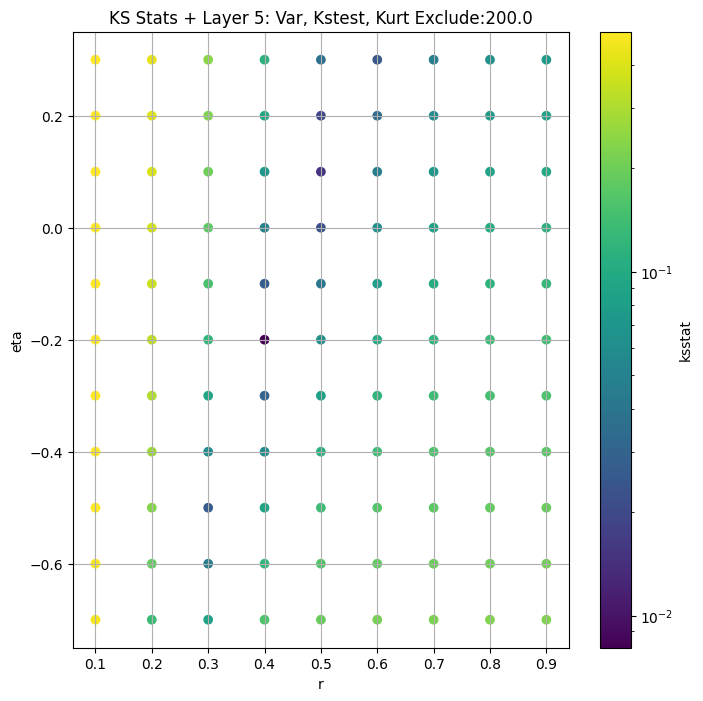

####
Layer  6


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 0 0.049632753548491226 70.41104


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 25 0.0065395769848088925 37.032257


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 50 0.006814818143205028 31.964481


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 75 0.01147528910446527 29.212294


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 100 0.008105179081385638 27.365221


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 150 0.00923477068769396 24.979393


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 200 0.008103884698330122 23.380512


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 250 0.008774896615936778 22.181648


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 300 0.009104982444762794 21.229595


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 350 0.007990703116500186 20.43804


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 500 0.0042575787350978 18.658548
Number of samples: 100000, Without approximation : 1152000


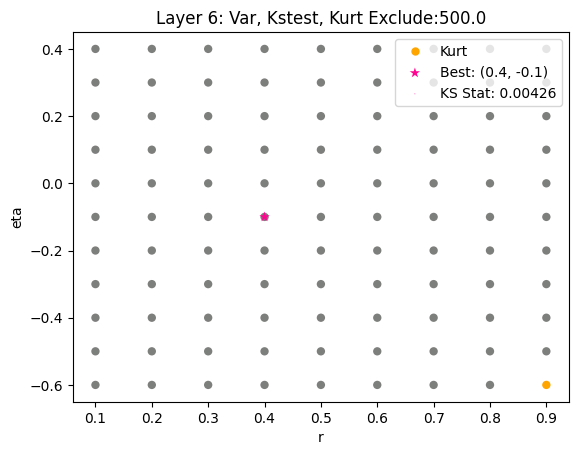

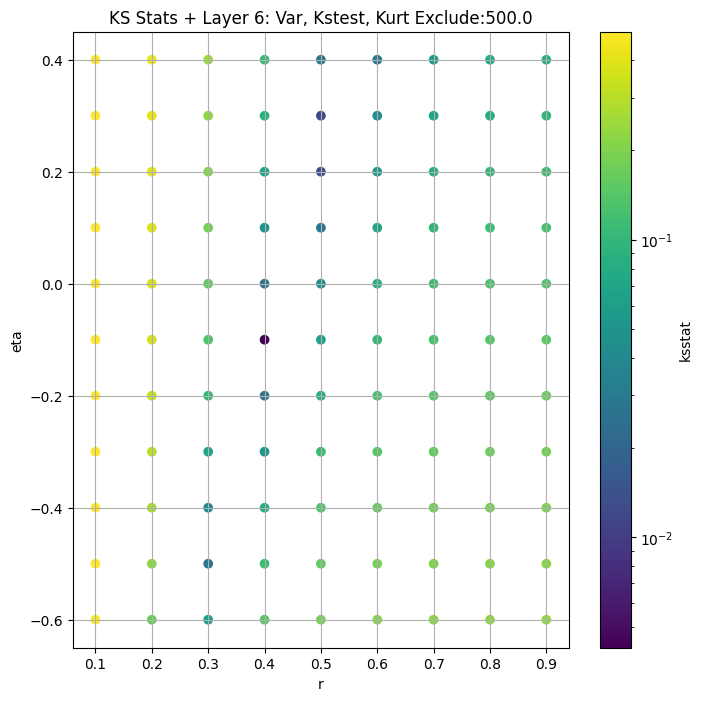

####
Layer  7


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 0 0.07585495309556511 23.222046


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 25 0.010769246363812712 12.74986


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 50 0.011418065833005801 11.209029


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 75 0.008482041267954212 10.34906


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 100 0.008108509958484666 9.771373


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 150 0.006208520394179507 8.996522


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 200 0.006606454608962475 8.475763


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 250 0.00792120097778077 8.088338


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 300 0.004726904996609122 7.779855


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 350 0.011474103957283096 7.524806


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
7 500 0.009837260594924624 6.9437704
Number of samples: 100000, Without approximation : 4608000


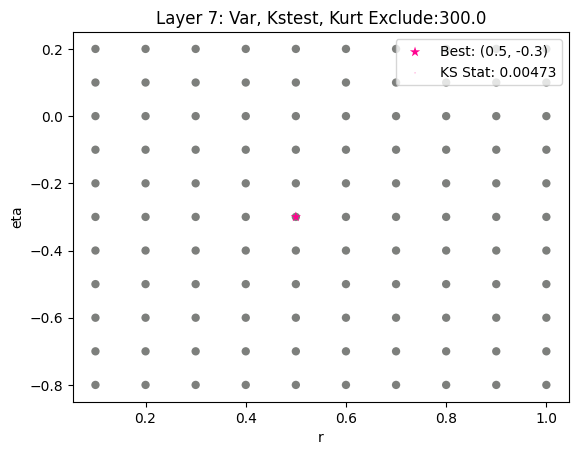

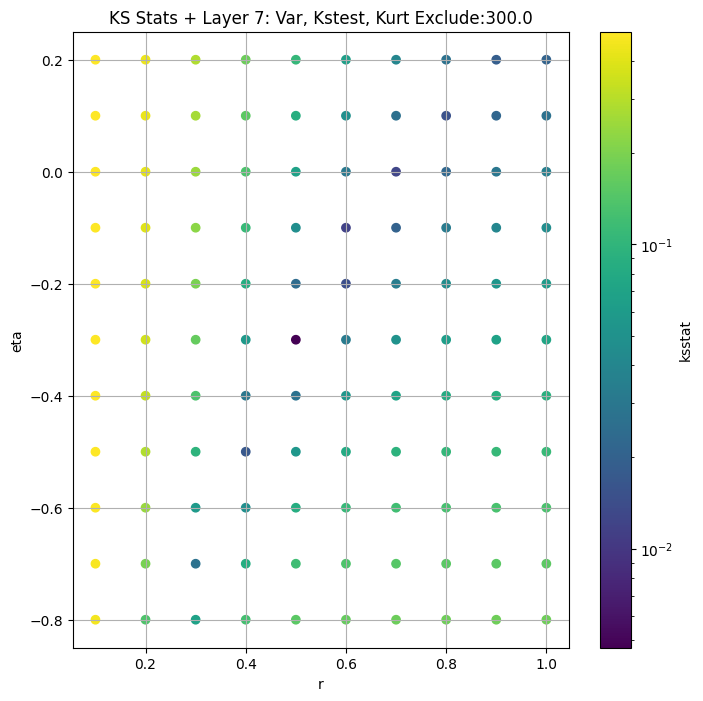

####
Layer  8


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 0 0.0793373553784138 9.512077


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 25 0.02956613632179511 5.0954876


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 50 0.01981592272139787 4.3802347


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 75 0.014202027405032625 3.9851885


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 100 0.011476900377982657 3.7232816


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 150 0.013860430409631364 3.3879926


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 200 0.010378602623949962 3.1733246


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 250 0.0100327031448888 3.016775


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 300 0.009847852608706242 2.893043


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 350 0.007929343413642875 2.7898018


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
8 500 0.009862819750194984 2.55203
Number of samples: 100000, Without approximation : 18432000


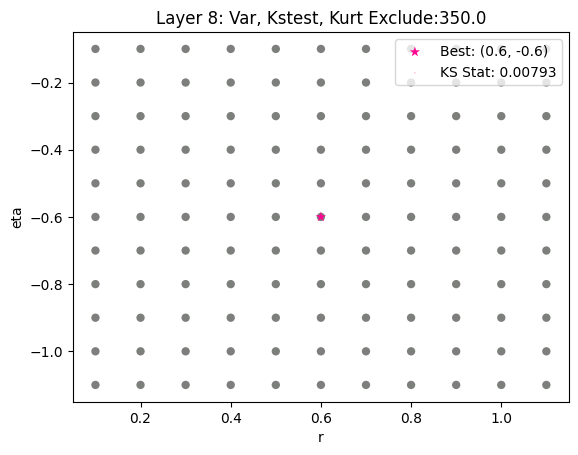

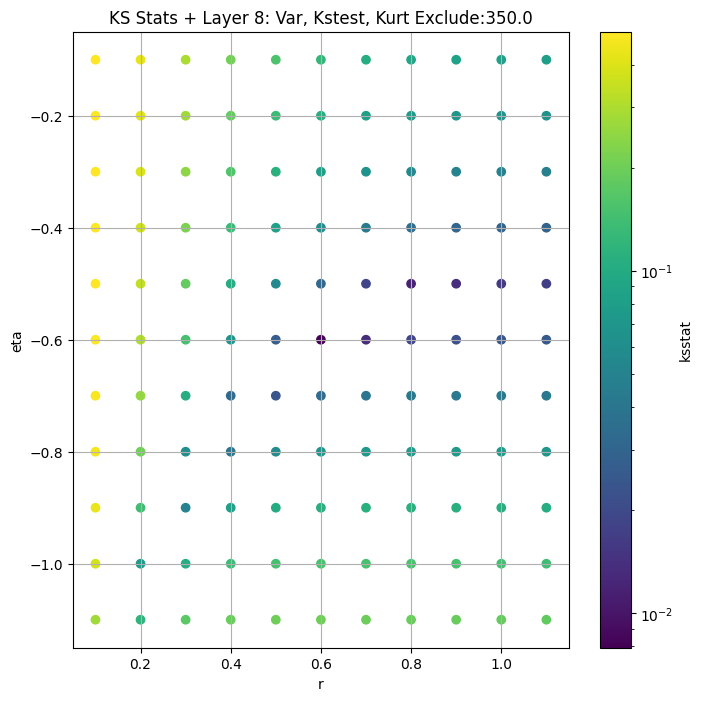

####
Layer  9


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 0 0.09947521756770644 1.696372


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 25 0.05603226492133673 1.0159965


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 50 0.04683446548812448 0.8748354


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 75 0.04476414409631896 0.7957624


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 100 0.039500826097124575 0.7436497


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 150 0.031544668153261235 0.6764354


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 200 0.02927201516436706 0.63194


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 250 0.02840241550017336 0.59845674


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 300 0.02761938037510675 0.57138604


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 350 0.023993610257300124 0.5485585


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
9 500 0.019146523206509614 0.49556962
Number of samples: 100000, Without approximation : 73728000


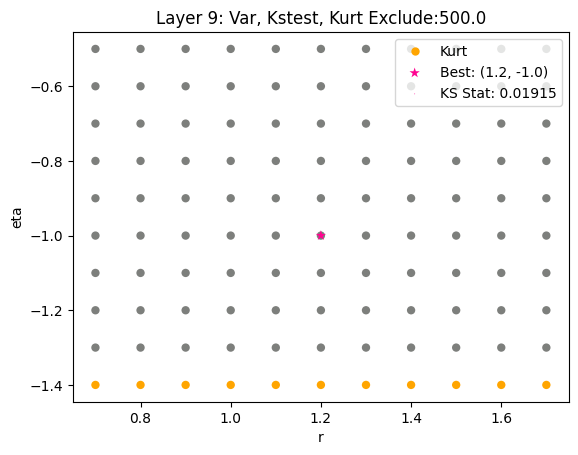

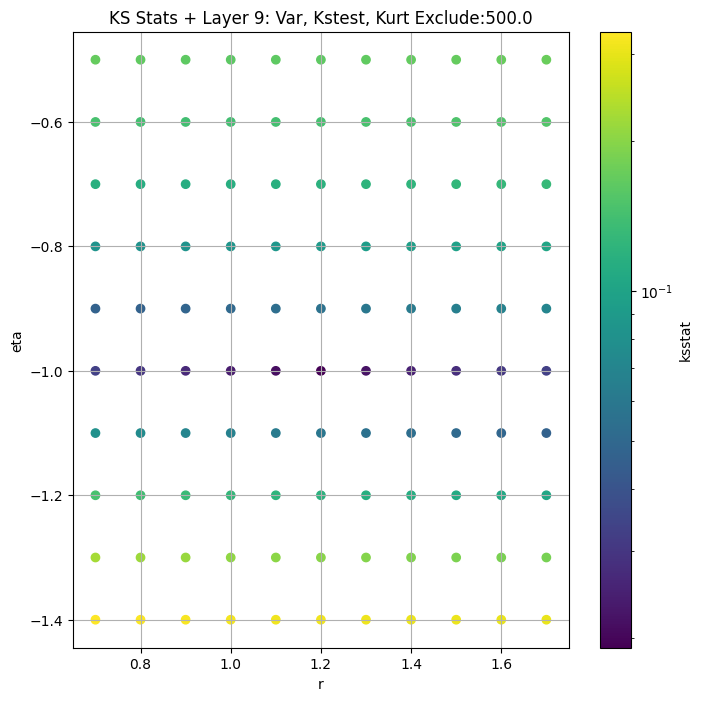

####
Layer  10


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 0 0.12861739128371796 0.18131718


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 25 0.0927963911766383 0.084603444


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 50 0.08235098251679673 0.07179656


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 75 0.07548707639293378 0.06481579


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 100 0.07379709371508125 0.060293887


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 150 0.07242837918640299 0.054487456


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 200 0.07107503571457363 0.050625764


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 250 0.07013910757191444 0.047699127


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 300 0.07033720743359018 0.04532334


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 350 0.0702915140723154 0.043312896


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
10 500 0.06952041049728563 0.03862823
Number of samples: 100000, Without approximation : 294912000


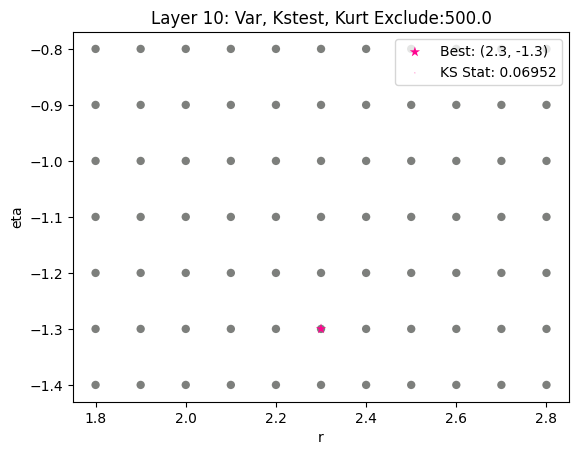

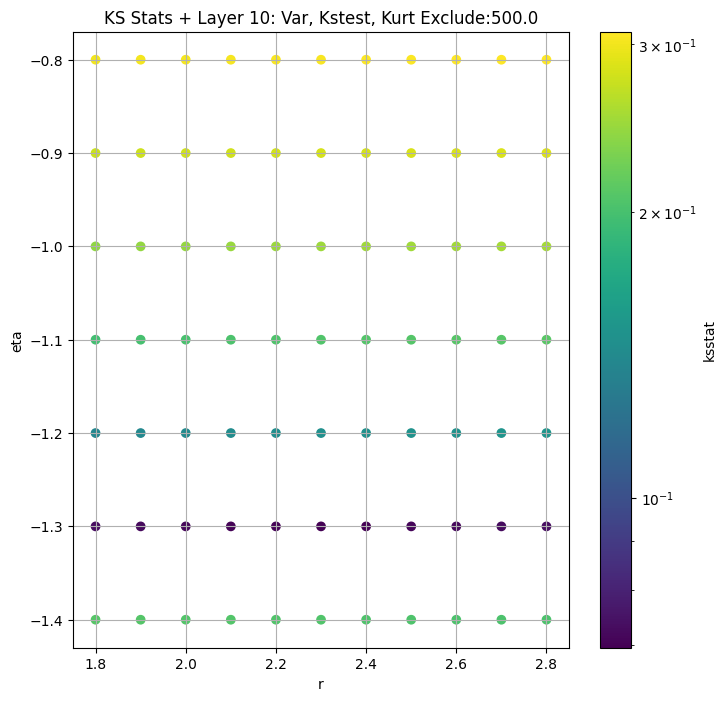

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      49450.980469  19202.867188  101513.000000   500.580811   93.005814   
3       8568.368164   4678.516113   14358.226562   487.672516  163.083923   
4       1787.585205    838.502747    3350.636475   762.550354  170.148346   
5        284.274750    138.199066     671.343445  1228.929688   86.793030   
6         70.411041     35.697952     185.533096  1638.797119   65.571648   
7         23.222046     12.280906      72.200691  2538.970459   51.936737   
8          9.512077      4.864893      27.376392  1990.125610   68.890762   
9          1.696372      0.967391       4.156639  1298.781494   67.881310   
10         0.181317      0.080193       0.812861  5574.856445   78.470016   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2       851.761047           4500             0.012758        0.2   
3       789.382874          18000             0.017256        0.4   
4      1375.016479          72000             0.011473        0.3   
5      3410.601807         288000             0.008072        0.4   
6      3892.750488        1152000             0.004258        0.4   
7      4483.448242        4608000             0.004727        0.5   
8      4263.745605       18432000             0.007929        0.6   
9      3193.164795       73728000             0.019147        1.2   
10     6336.022949      294912000             0.069520        2.3   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              0.2       0.076602                   150.0         3824.677734   
3             -0.4      54.795021                     0.0         8568.368164   
4             -0.1       0.788835                   350.0          308.454254   
5             -0.2       1.909787                   200.0           82.792633   
6             -0.1       0.595735                   500.0           18.658548   
7             -0.3       0.918307                   300.0            7.779855   
8             -0.6       0.976701                   350.0            2.789802   
9             -1.0       1.204561                   500.0            0.495570   
10            -1.3       0.905368                   500.0            0.038628   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.020208  
3                     0.010113  
4                     0.005059  
5                     0.002530  
6                     0.001265  
7                     0.000633  
8                     0.000316  
9                     0.000158  
10                    0.000079

In [21]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
            
            if exclude_cutoff == 0:
                augmented_kurt = stats.kurtosis(group_data_map[group]) 
            else:
                augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_kurt == stats.kurtosis(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
            #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        #fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    #master_df.to_csv(master_df_combo_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    #augmented_var_df.to_csv(augmented_var_df_path)

#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
#master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [22]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + 100 = 250, ksstat: nan, var: 2562.221923828125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + 75 = 225, ksstat: nan, var: 2808.245849609375


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + 50 = 200, ksstat: nan, var: 3097.633544921875


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + 25 = 175, ksstat: nan, var: 3429.955078125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + 0 = 150, ksstat: nan, var: 3824.677734375


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + -25 = 125, ksstat: nan, var: 4305.44873046875


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + -50 = 100, ksstat: nan, var: 4890.15673828125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + -75 = 75, ksstat: nan, var: 5650.314453125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 150.0 + -100 = 50, ksstat: nan, var: 6782.84375
Number of samples: 4500, Without approximation : 4500


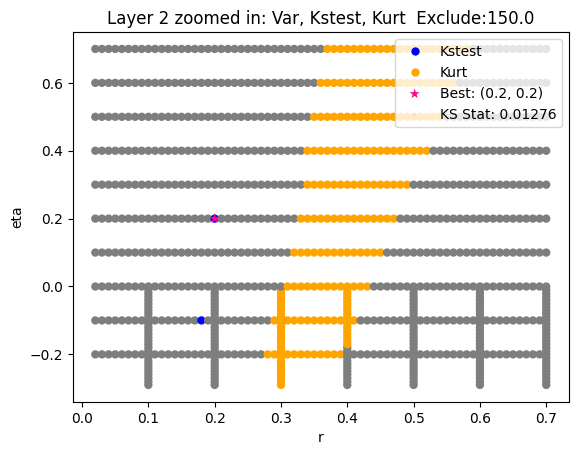

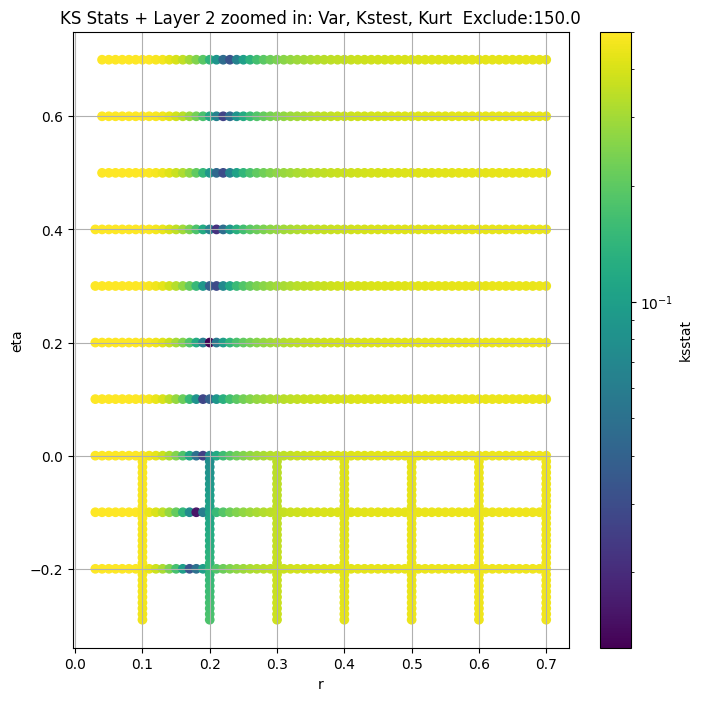

Layer 3


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 3, 0.0 + 100 = 100, ksstat: nan, var: 1609.8797607421875


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 3, 0.0 + 75 = 75, ksstat: nan, var: 1782.67919921875


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 3, 0.0 + 50 = 50, ksstat: nan, var: 2043.1405029296875


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 3, 0.0 + 25 = 25, ksstat: nan, var: 2502.127197265625


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 3, 0.0 + 0 = 0, ksstat: nan, var: 8568.3681640625
Number of samples: 18000, Without approximation : 18000


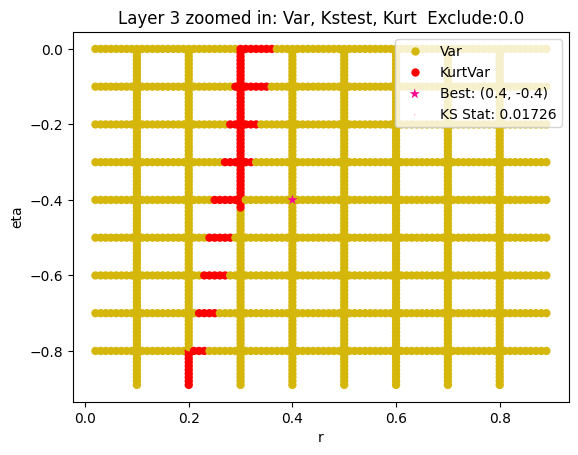

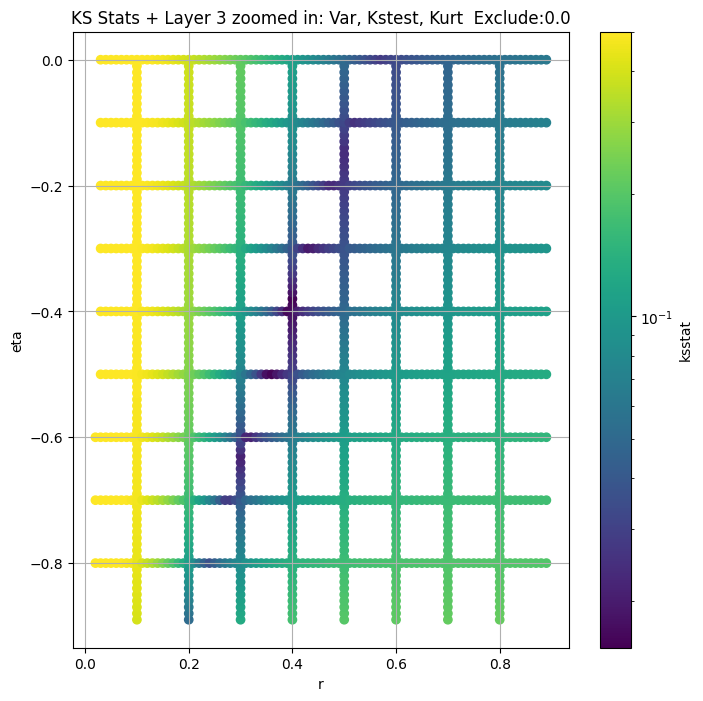

Layer 4


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + 100 = 450, ksstat: nan, var: 279.7984313964844


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + 75 = 425, ksstat: nan, var: 286.2762756347656


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + 50 = 400, ksstat: nan, var: 293.1268615722656


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + 25 = 375, ksstat: nan, var: 300.4925842285156


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + 0 = 350, ksstat: nan, var: 308.4542541503906


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + -25 = 325, ksstat: nan, var: 317.1174011230469


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + -50 = 300, ksstat: nan, var: 326.57769775390625


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + -75 = 275, ksstat: nan, var: 336.9877624511719


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 4, 350.0 + -100 = 250, ksstat: nan, var: 348.4391174316406
Number of samples: 72000, Without approximation : 72000


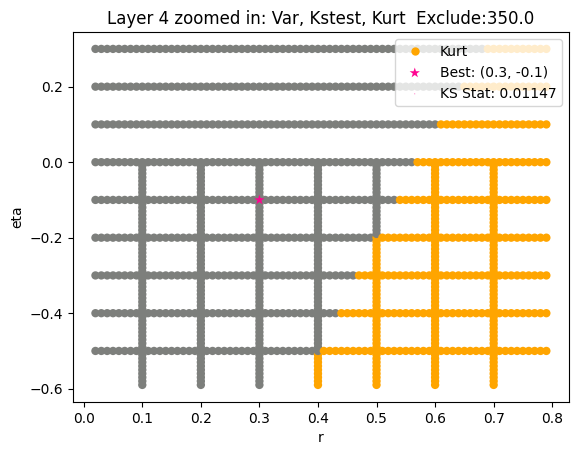

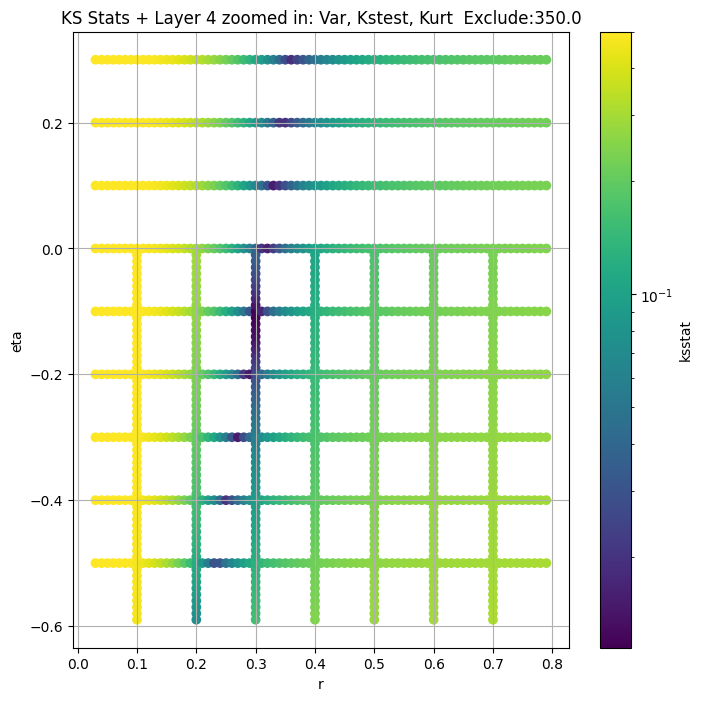

Layer 5


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + 100 = 300, ksstat: nan, var: 73.37428283691406


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + 75 = 275, ksstat: nan, var: 75.36203002929688


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + 50 = 250, ksstat: nan, var: 77.55980682373047


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + 25 = 225, ksstat: nan, var: 80.01958465576172


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + 0 = 200, ksstat: nan, var: 82.79263305664062


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + -25 = 175, ksstat: nan, var: 86.04106140136719


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + -50 = 150, ksstat: nan, var: 89.89384460449219


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + -75 = 125, ksstat: nan, var: 94.54680633544922


  0%|          | 0/1384 [00:00<?, ?it/s]

Finding Minimum after computing 1384 CDFs
layer 5, 200.0 + -100 = 100, ksstat: nan, var: 100.49852752685547
Number of samples: 100000, Without approximation : 288000


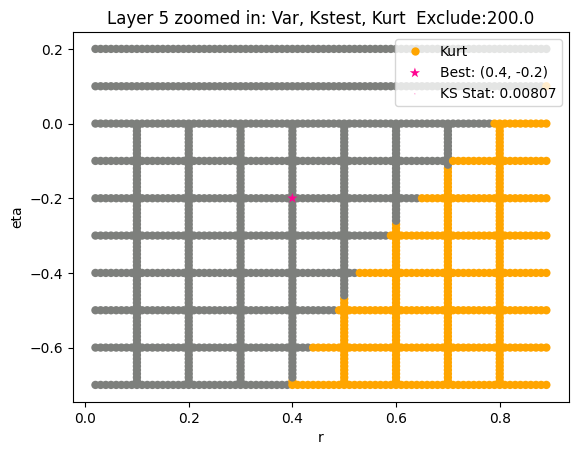

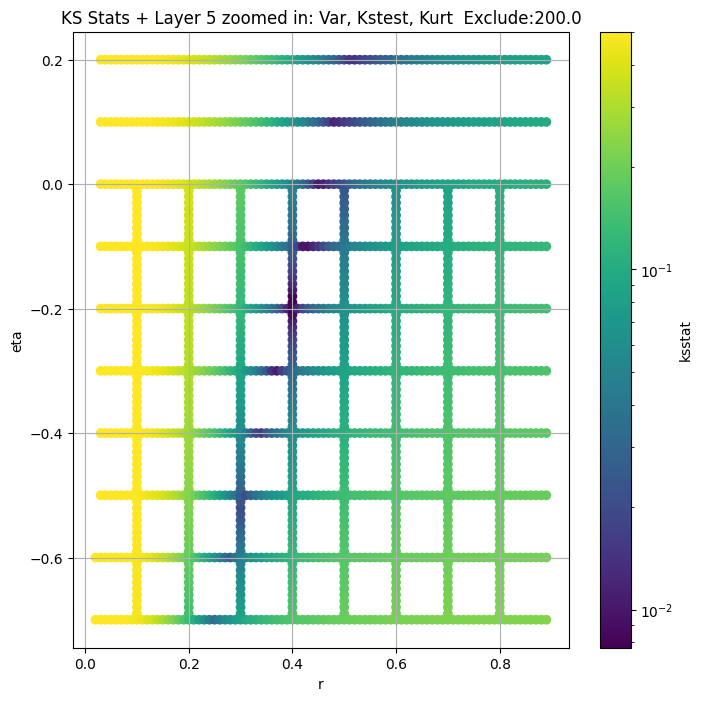

Layer 6


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + 100 = 600, ksstat: nan, var: 17.769500732421875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + 75 = 575, ksstat: nan, var: 17.97670555114746


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + 50 = 550, ksstat: nan, var: 18.193397521972656


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + 25 = 525, ksstat: nan, var: 18.420406341552734


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + 0 = 500, ksstat: nan, var: 18.65854835510254


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + -25 = 475, ksstat: nan, var: 18.90996551513672


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + -50 = 450, ksstat: nan, var: 19.1760196685791


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + -75 = 425, ksstat: nan, var: 19.45892906188965


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 6, 500.0 + -100 = 400, ksstat: nan, var: 19.76154899597168
Number of samples: 100000, Without approximation : 1152000


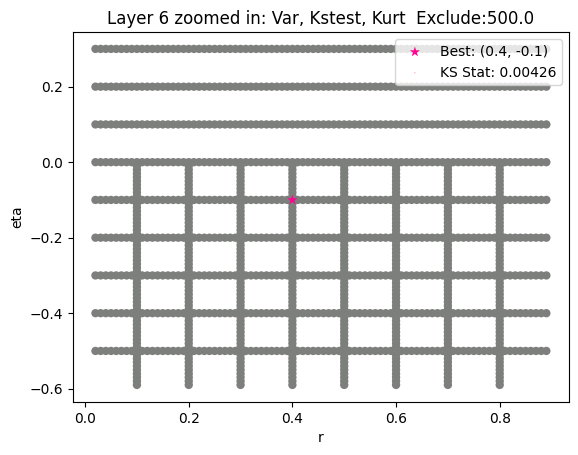

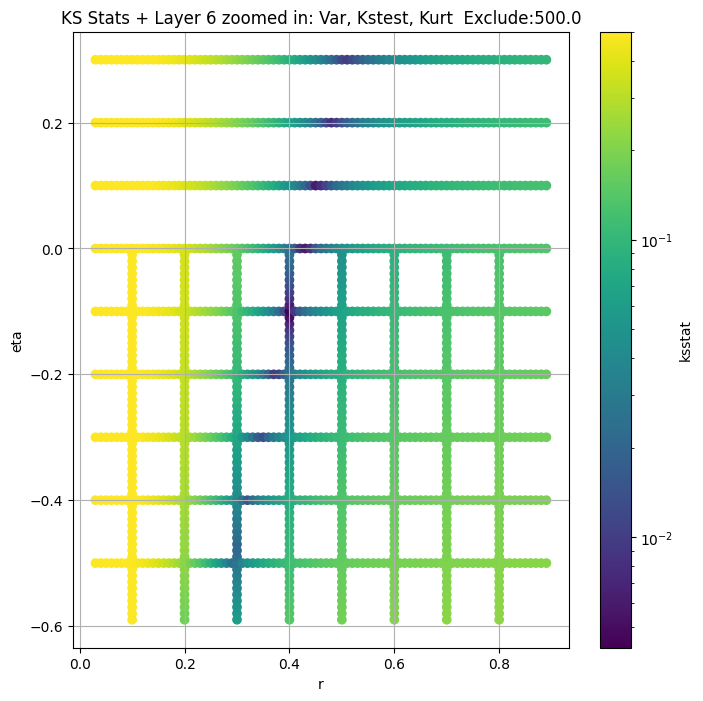

Layer 7


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + 100 = 400, ksstat: nan, var: 7.306326389312744


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + 75 = 375, ksstat: nan, var: 7.411831378936768


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + 50 = 350, ksstat: nan, var: 7.524806022644043


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + 25 = 325, ksstat: nan, var: 7.646897792816162


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + 0 = 300, ksstat: nan, var: 7.779854774475098


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + -25 = 275, ksstat: nan, var: 7.9260993003845215


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + -50 = 250, ksstat: nan, var: 8.088337898254395


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + -75 = 225, ksstat: nan, var: 8.269654273986816


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 7, 300.0 + -100 = 200, ksstat: nan, var: 8.475763320922852
Number of samples: 100000, Without approximation : 4608000


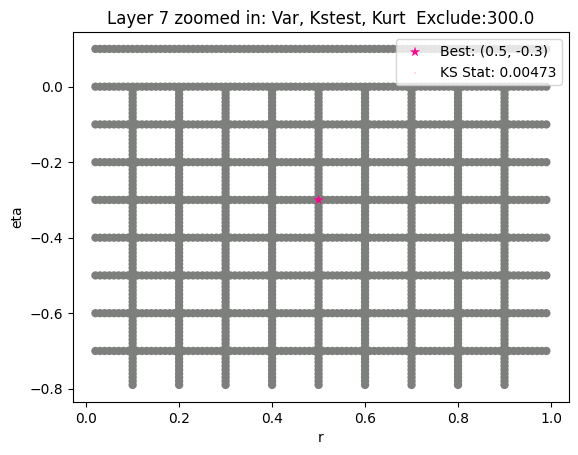

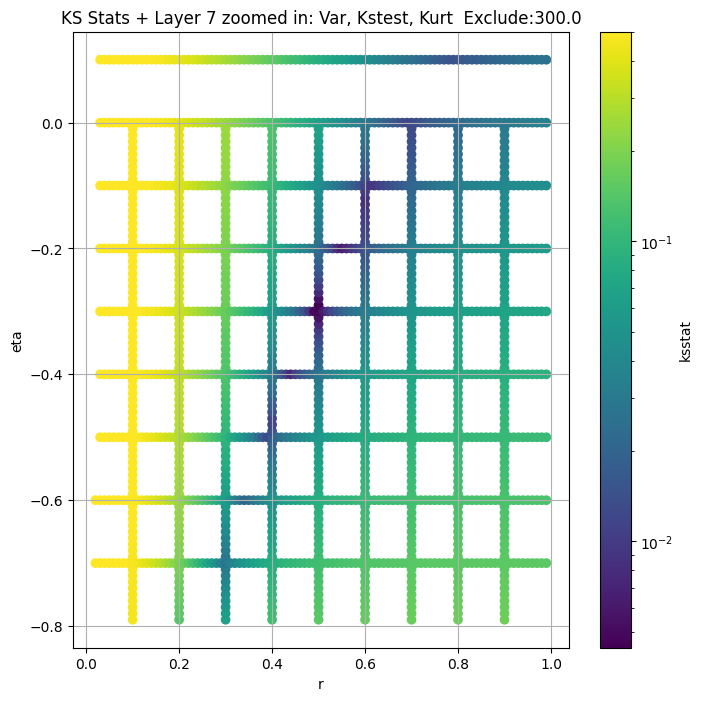

Layer 8


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + 100 = 450, ksstat: 0.007627633460092764, var: 2.622305393218994


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + 75 = 425, ksstat: 0.007290848361353963, var: 2.660390615463257


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + 50 = 400, ksstat: 0.007230129480828129, var: 2.7007687091827393


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + 25 = 375, ksstat: 0.006989330538791583, var: 2.743762493133545


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + 0 = 350, ksstat: 0.007009160255420643, var: 2.789801836013794


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + -25 = 325, ksstat: 0.007102584542118984, var: 2.839355230331421


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + -50 = 300, ksstat: 0.0074775930125965395, var: 2.893043041229248


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + -75 = 275, ksstat: 0.008094628914646906, var: 2.951779842376709


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 8, 350.0 + -100 = 250, ksstat: 0.008064217217521374, var: 3.016774892807007
Number of samples: 100000, Without approximation : 18432000


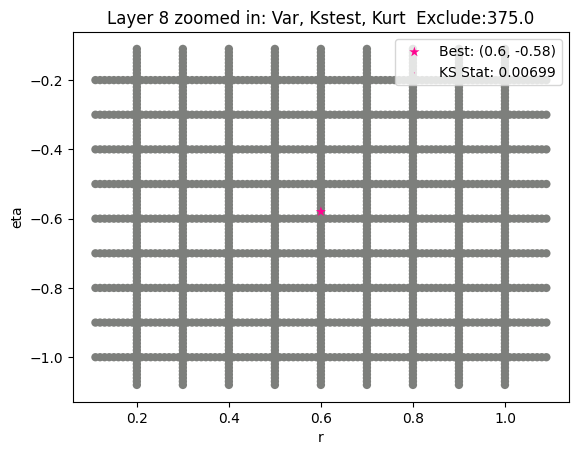

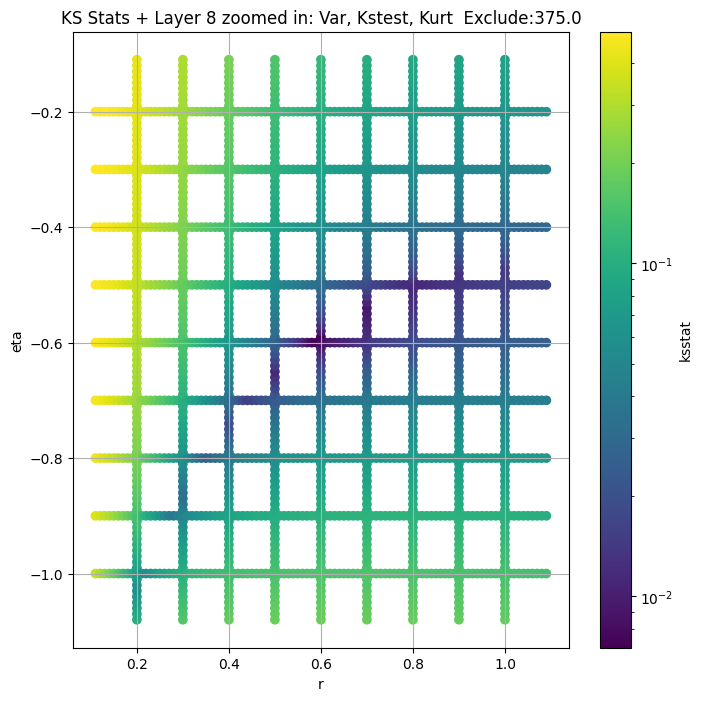

Layer 9


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.017525383891057622, var: 0.46823325753211975


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.018139123292844506, var: 0.47463366389274597


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.01837244093345114, var: 0.48130548000335693


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.018840126104731292, var: 0.4882751405239105


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.019146523206509614, var: 0.4955696165561676


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.0195009931829207, var: 0.503223180770874


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.019901091406203886, var: 0.5112766027450562


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.020549852870474616, var: 0.5197728276252747


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.021214680739032876, var: 0.5287699103355408
Number of samples: 100000, Without approximation : 73728000


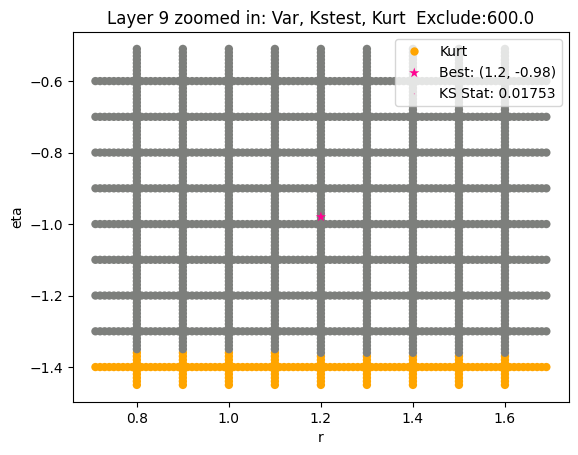

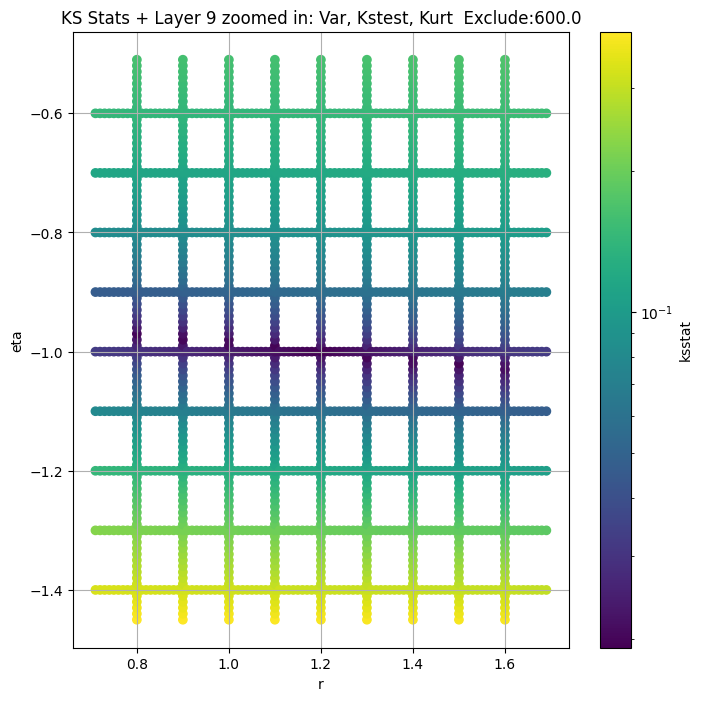

Layer 10


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + 100 = 600, ksstat: 0.0660343263116906, var: 0.03621126711368561


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + 75 = 575, ksstat: 0.06631581165904743, var: 0.03677671030163765


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + 50 = 550, ksstat: 0.0668539717509197, var: 0.03736654669046402


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + 25 = 525, ksstat: 0.0682983102796643, var: 0.03798287734389305


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + 0 = 500, ksstat: 0.06952041049728563, var: 0.0386282317340374


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + -25 = 475, ksstat: 0.06941020122570052, var: 0.039305564016103745


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + -50 = 450, ksstat: 0.06944552393633183, var: 0.04001808911561966


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + -75 = 425, ksstat: 0.06943510925558359, var: 0.0407697893679142


  0%|          | 0/345 [00:00<?, ?it/s]

Finding Minimum after computing 345 CDFs
layer 10, 500.0 + -100 = 400, ksstat: 0.06948553523548728, var: 0.0415654331445694
Number of samples: 100000, Without approximation : 294912000


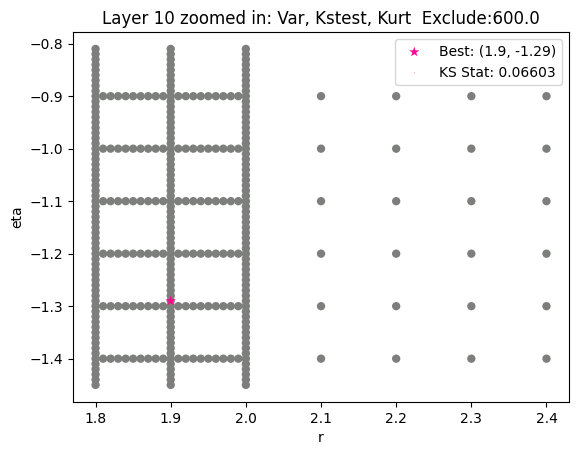

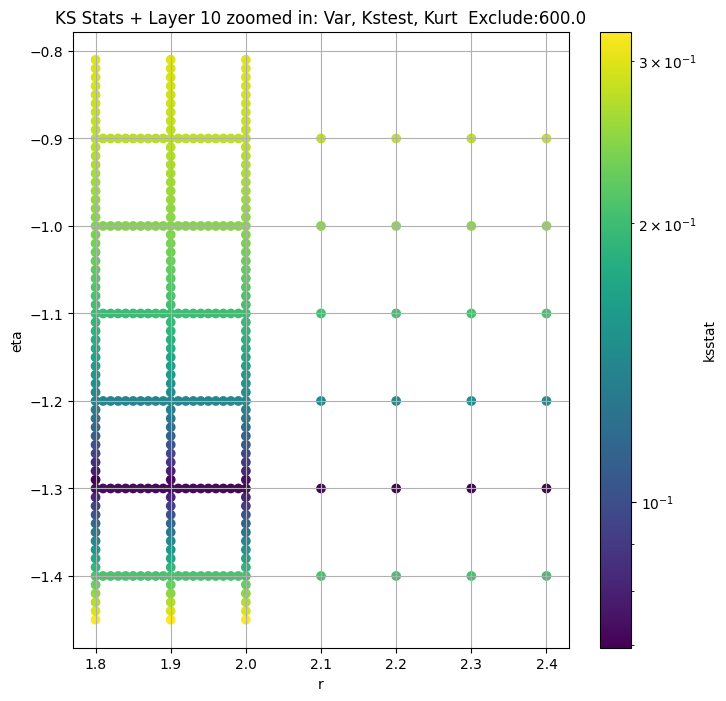

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      49450.980469  19202.867188  101513.000000   500.580811   93.005814   
3       8568.368164   4678.516113   14358.226562   487.672516  163.083923   
4       1787.585205    838.502747    3350.636475   762.550354  170.148346   
5        284.274750    138.199066     671.343445  1228.929688   86.793030   
6         70.411041     35.697952     185.533096  1638.797119   65.571648   
7         23.222046     12.280906      72.200691  2538.970459   51.936737   
8          9.512077      4.864893      27.376392  1990.125610   68.890762   
9          1.696372      0.967391       4.156639  1298.781494   67.881310   
10         0.181317      0.080193       0.812861  5574.856445   78.470016   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2       851.761047           4500             0.012758        0.2   
3       789.382874          18000             0.017256        0.4   
4      1375.016479          72000             0.011473        0.3   
5      3410.601807         288000             0.008072        0.4   
6      3892.750488        1152000             0.004258        0.4   
7      4483.448242        4608000             0.004727        0.5   
8      4263.745605       18432000             0.007929        0.6   
9      3193.164795       73728000             0.019147        1.2   
10     6336.022949      294912000             0.069520        2.3   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              0.2       0.076602                   150.0         3824.677734   
3             -0.4      54.795021                     0.0         8568.368164   
4             -0.1       0.788835                   350.0          308.454254   
5             -0.2       1.909787                   200.0           82.792633   
6             -0.1       0.595735                   500.0           18.658548   
7             -0.3       0.918307                   300.0            7.779855   
8             -0.6       0.976701                   350.0            2.743762   
9             -1.0       1.204561                   500.0            0.468233   
10            -1.3       0.905368                   500.0            0.036211   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.020208          0.012758     0.2      0.20   
3                     0.010113          0.017256     0.4     -0.40   
4                     0.005059          0.011473     0.3     -0.10   
5                     0.002530          0.008072     0.4     -0.20   
6                     0.001265          0.004258     0.4     -0.10   
7                     0.000633          0.004727     0.5     -0.30   
8                     0.000316          0.006989     0.6     -0.58   
9                     0.000158          0.017525     1.2     -0.98   
10                    0.000079          0.066034     1.9     -1.29   

       best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                
2        0.076602                150.0        11389  
3       54.795021                  0.0         6405  
4        0.788835                350.0        13500  
5        1.909787                200.0        27000  
6        0.595735                500.0       102514  
7        0.918307                300.0        81000  
8        0.950919                375.0        36000  
9        1.109280                600.0         5694  
10       0.785966                600.0          421

In [23]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff]) 
                                        
                if exclude_cutoff == 0:
                    augmented_kurt = stats.kurtosis(group_data_map[group])
                else:
                    augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])

                group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
                #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            #fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
   #master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    #augmented_var_df.to_csv(augmented_var_df_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
#master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

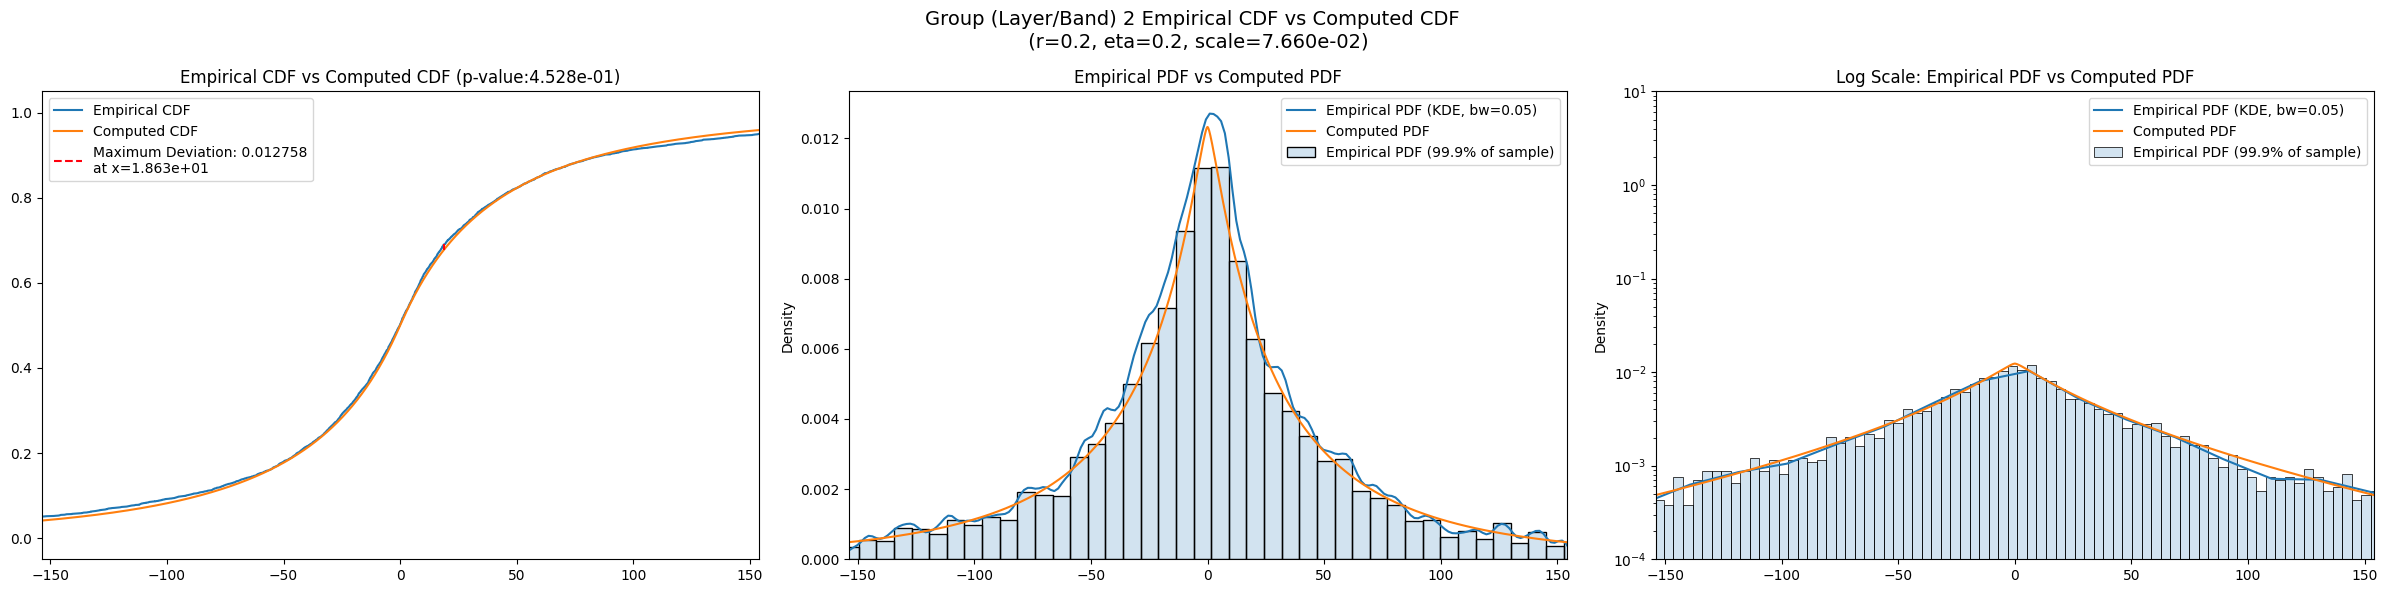

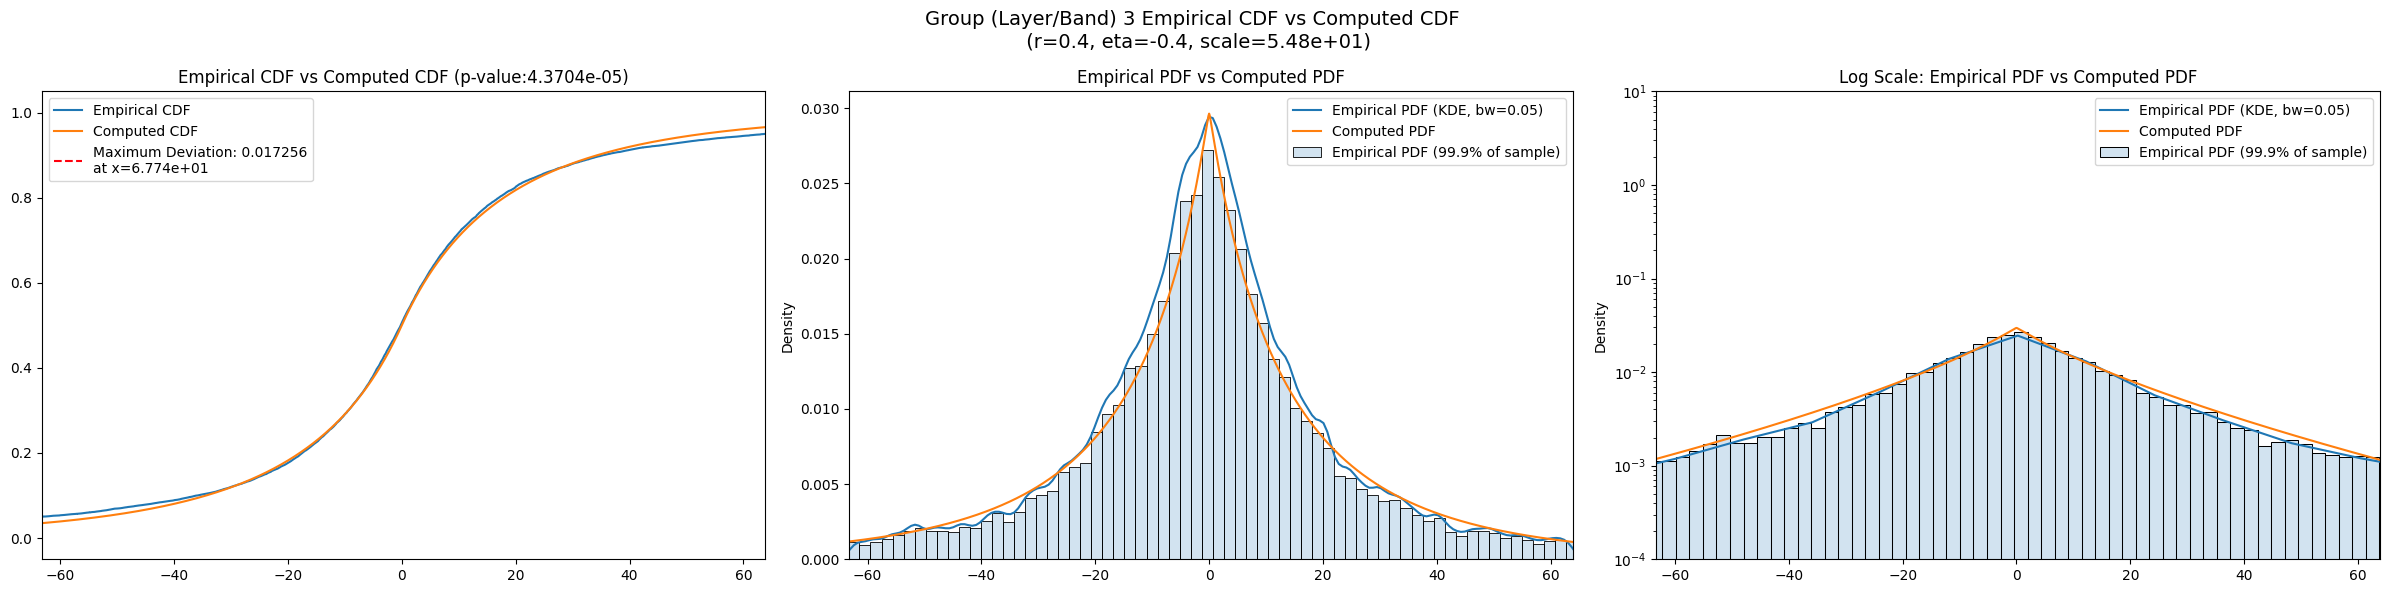

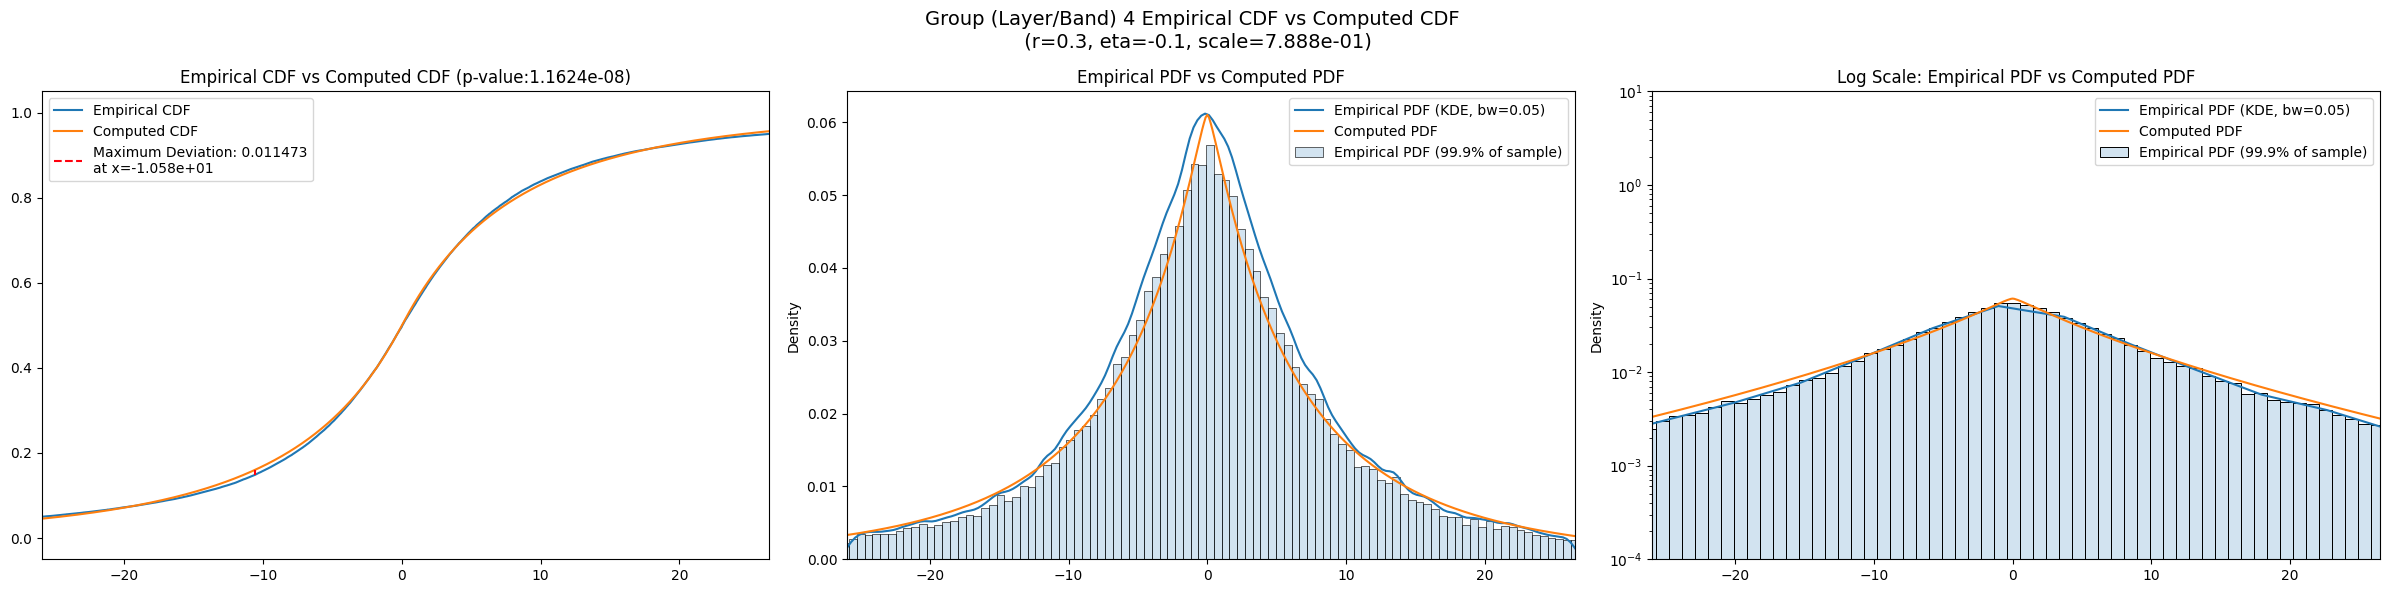

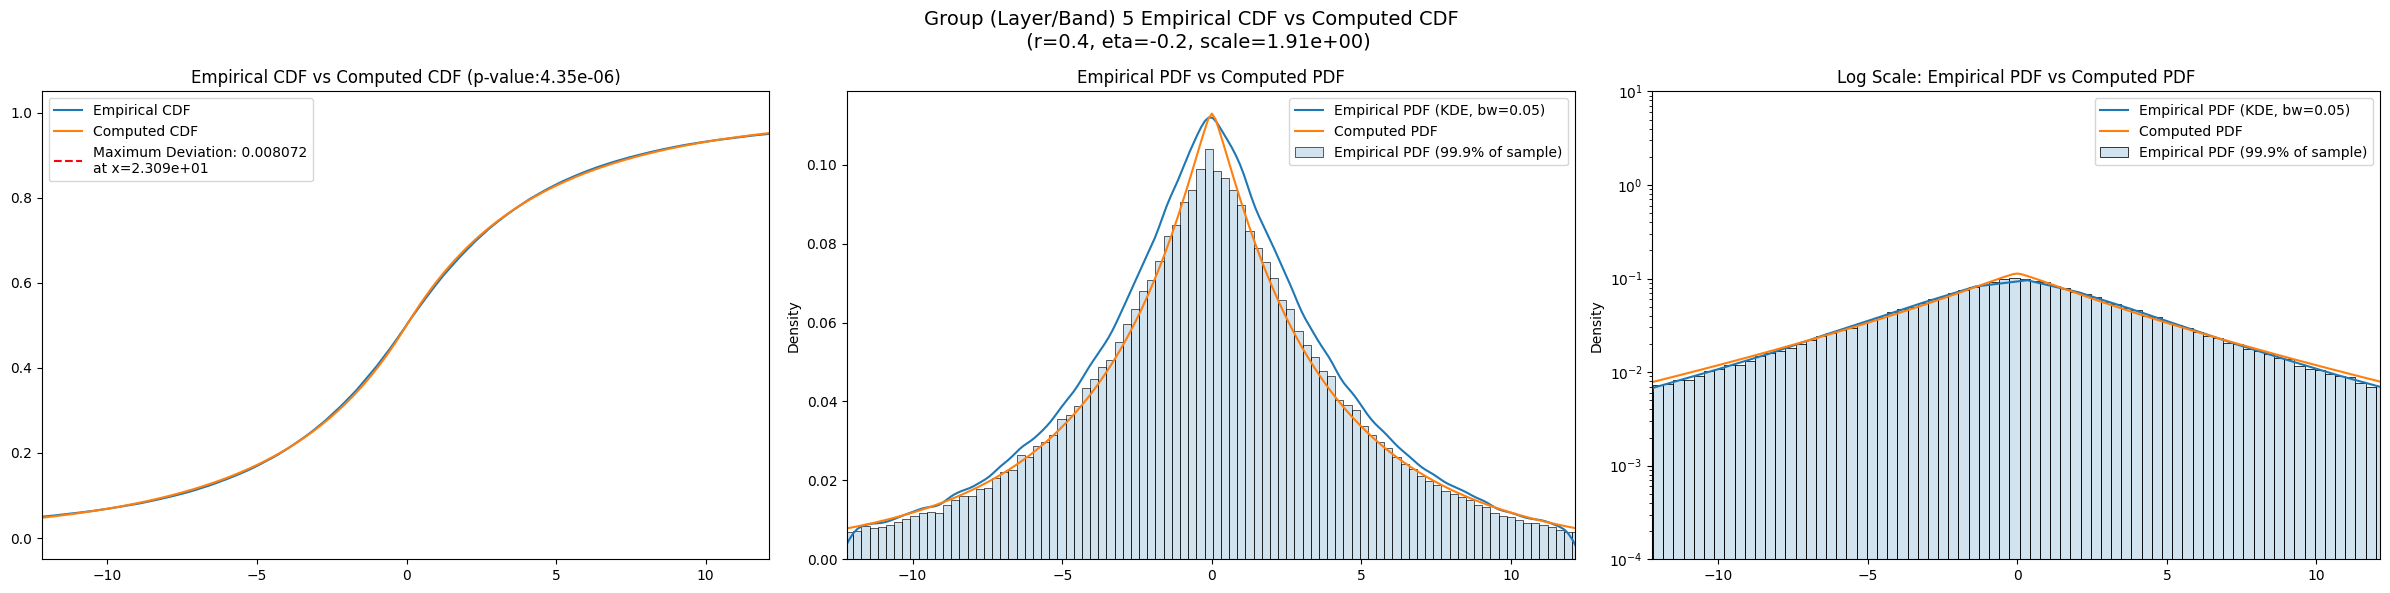

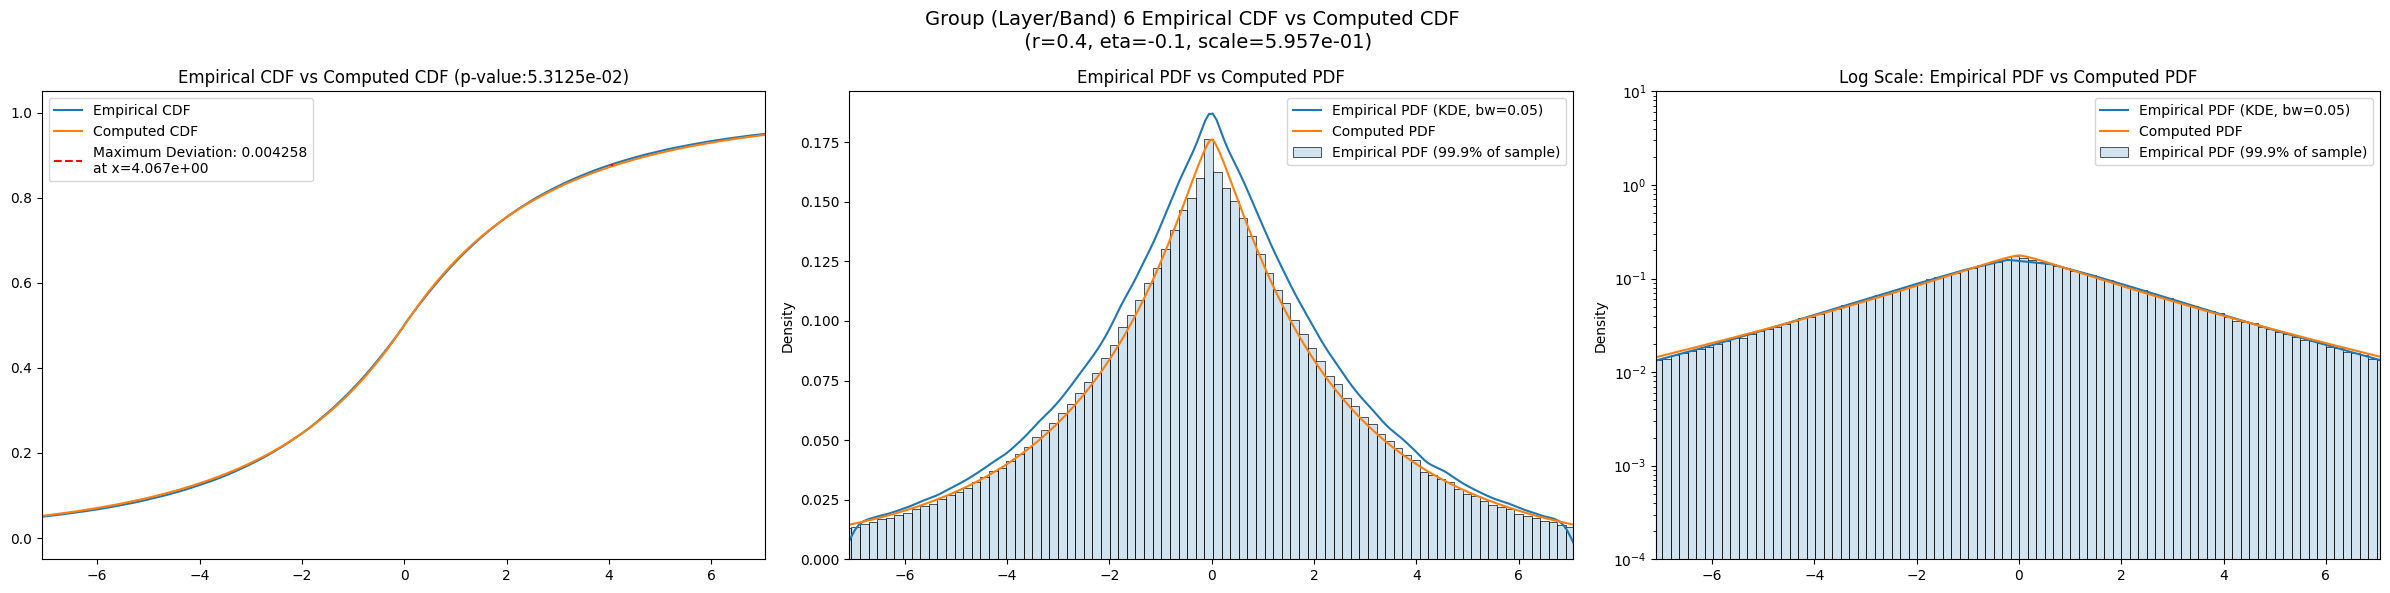

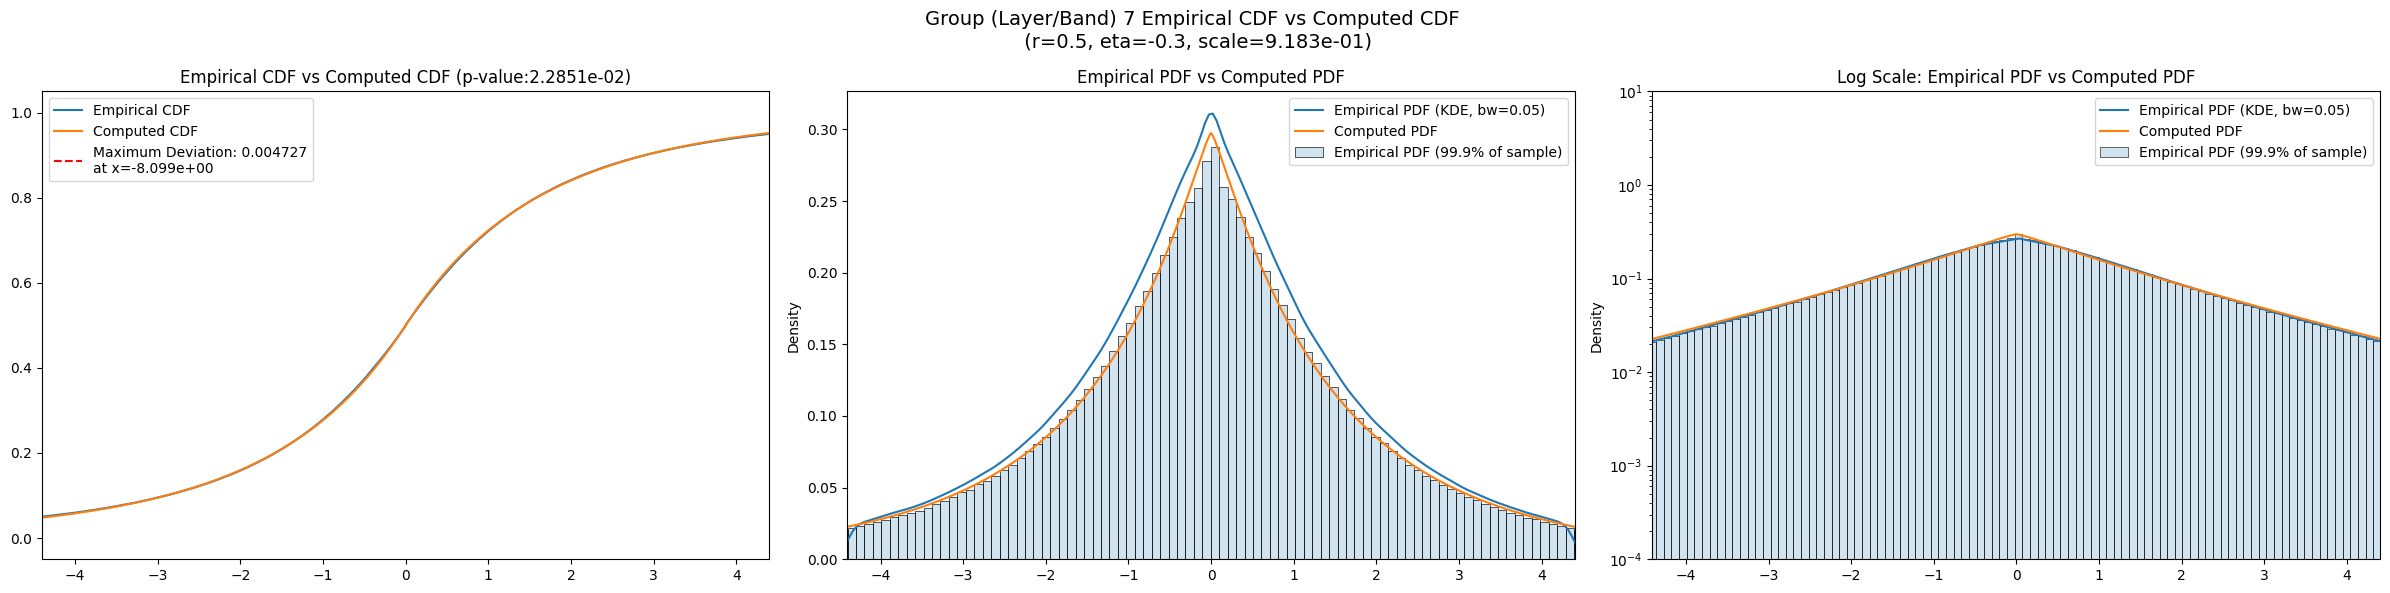

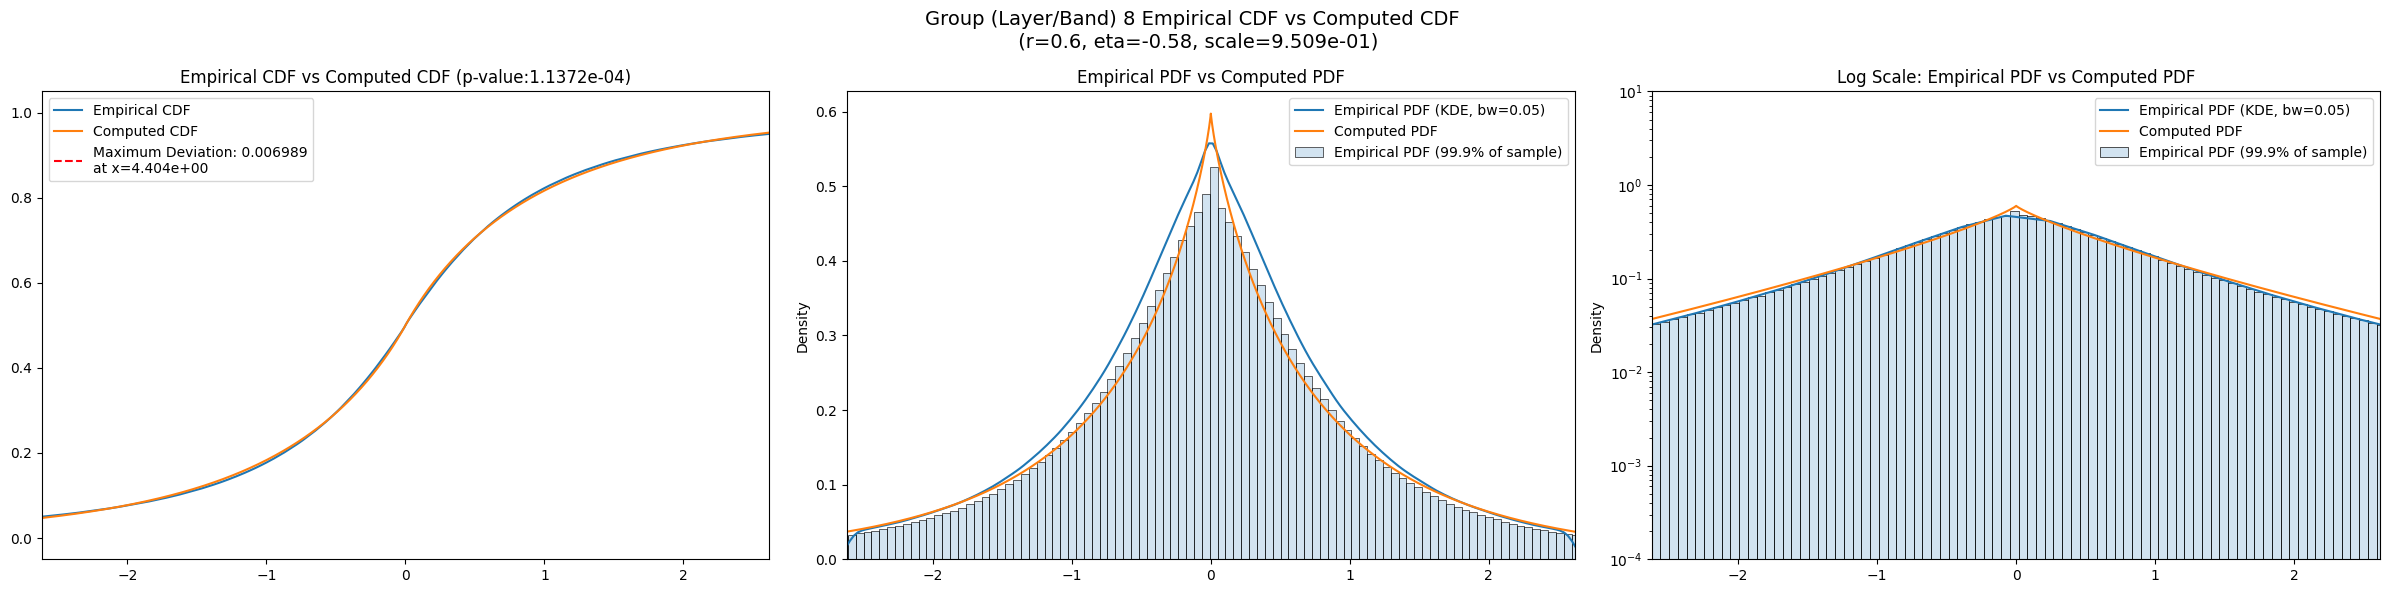

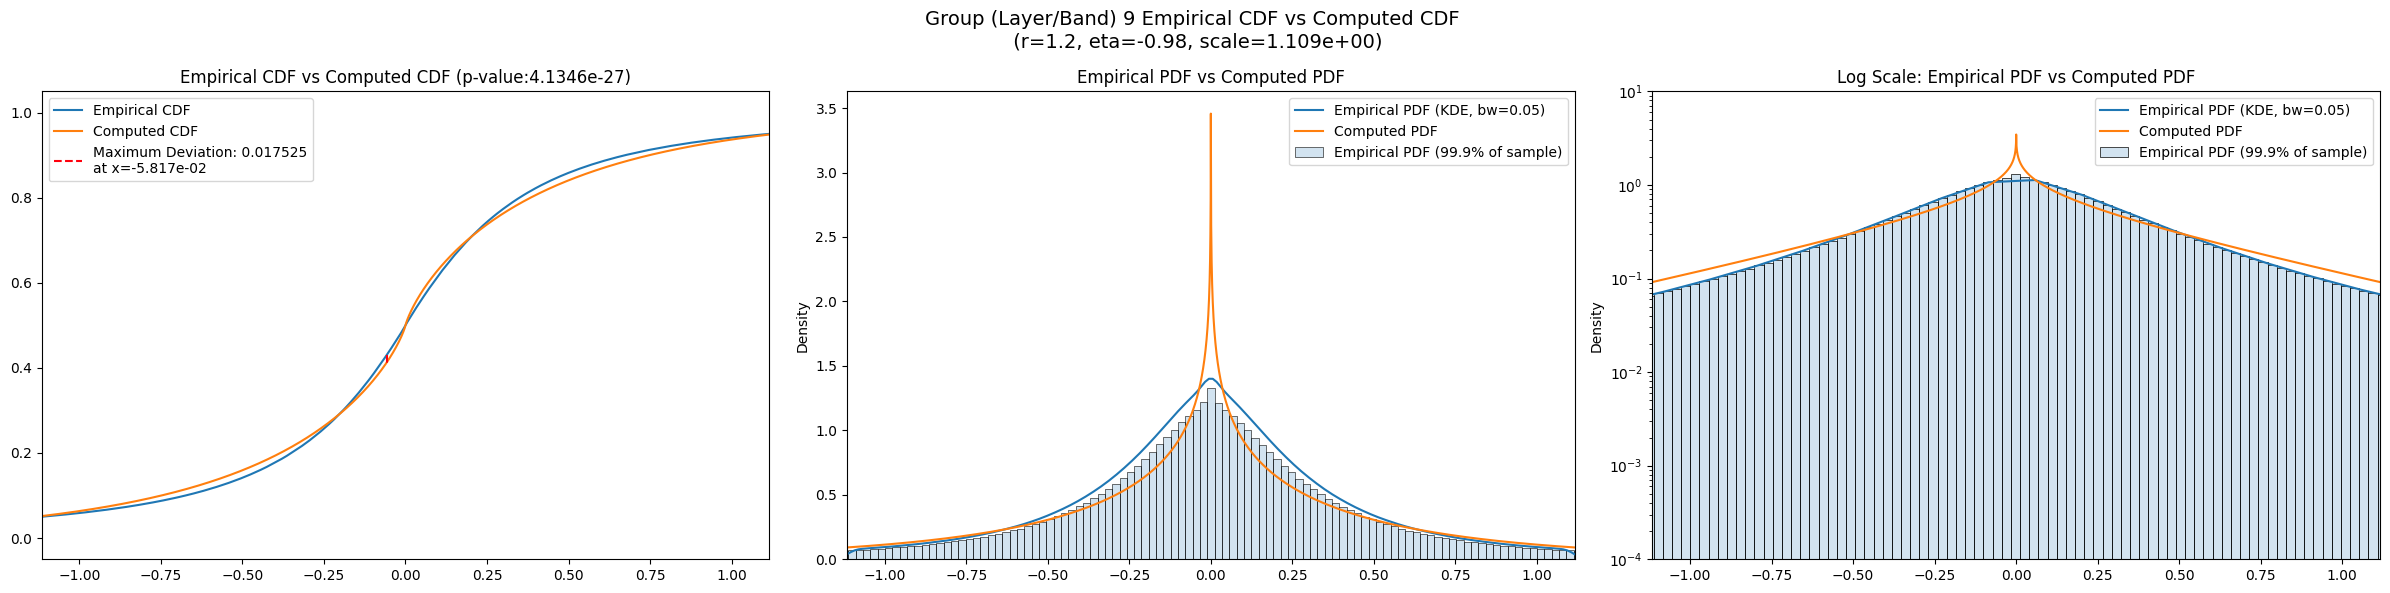

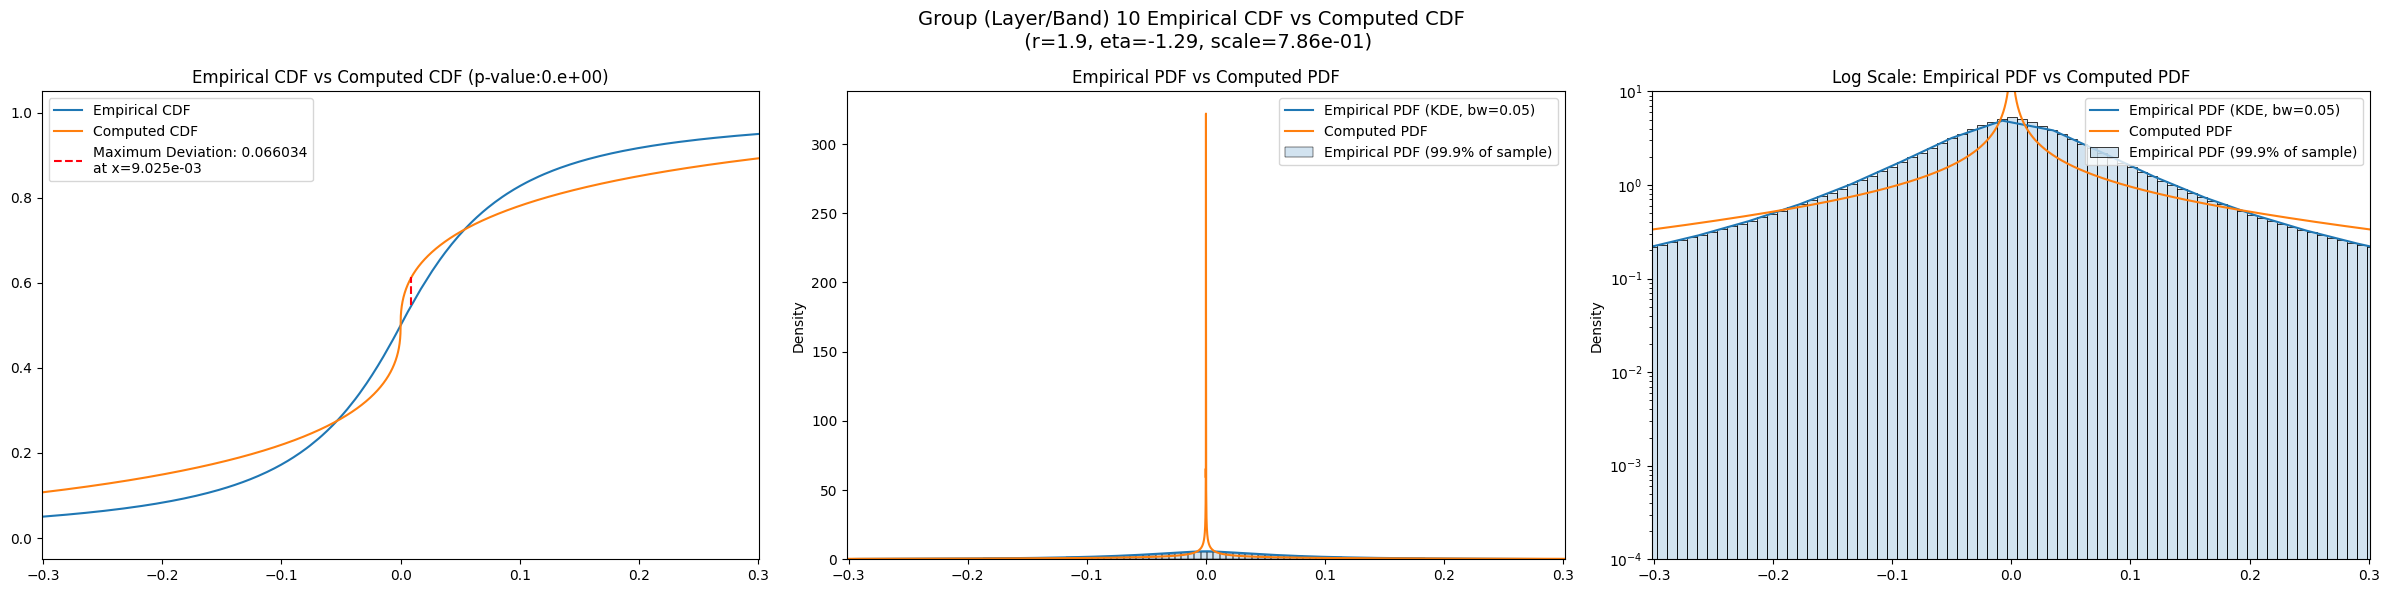

In [24]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    #fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [25]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [26]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
#master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      49450.980469  19202.867188  101513.000000   500.580811   93.005814   
3       8568.368164   4678.516113   14358.226562   487.672516  163.083923   
4       1787.585205    838.502747    3350.636475   762.550354  170.148346   
5        284.274750    138.199066     671.343445  1228.929688   86.793030   
6         70.411041     35.697952     185.533096  1638.797119   65.571648   
7         23.222046     12.280906      72.200691  2538.970459   51.936737   
8          9.512077      4.864893      27.376392  1990.125610   68.890762   
9          1.696372      0.967391       4.156639  1298.781494   67.881310   
10         0.181317      0.080193       0.812861  5574.856445   78.470016   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2       851.761047           4500             0.012758        0.2   
3       789.382874          18000             0.017256        0.4   
4      1375.016479          72000             0.011473        0.3   
5      3410.601807         288000             0.008072        0.4   
6      3892.750488        1152000             0.004258        0.4   
7      4483.448242        4608000             0.004727        0.5   
8      4263.745605       18432000             0.007929        0.6   
9      3193.164795       73728000             0.019147        1.2   
10     6336.022949      294912000             0.069520        2.3   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2              0.2  ...       55.800300              0.058552   
3             -0.4  ...       23.543900              0.053350   
4             -0.1  ...       10.618400              0.046225   
5             -0.2  ...        5.547130              0.036680   
6             -0.1  ...        3.349860              0.033279   
7             -0.3  ...        2.049100              0.034861   
8             -0.6  ...        1.162750              0.038688   
9             -1.0  ...        0.471521              0.042282   
10            -1.3  ...        0.116578              0.048023   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2              7.489670e-14      49.049200             0.031303   
3              5.737350e-45      20.869100             0.027808   
4             3.961540e-134       9.457180             0.022413   
5              0.000000e+00       4.927110             0.013401   
6              0.000000e+00       2.963890             0.008770   
7              0.000000e+00       1.808090             0.009213   
8              0.000000e+00       1.027530             0.013645   
9              0.000000e+00       0.418557             0.017977   
10             0.000000e+00       0.103959             0.024089   

       kstest_pval_laplace    param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                 
2             2.892480e-04  39.238500       0.030225   5.261340e-04   
3             1.589670e-12  16.383900       0.023971   2.038670e-09   
4             7.525710e-32   7.508340       0.016187   8.101830e-17   
5             2.342940e-45   3.892280       0.007875   6.107500e-16   
6             2.171450e-77   2.384540       0.007074   1.662680e-50   
7             0.000000e+00   1.458480       0.008158  8.779550e-267   
8             0.000000e+00   0.820434       0.009676   0.000000e+00   
9             0.000000e+00   0.331450       0.012137   0.000000e+00   
10            0.000000e+00   0.082002       0.017514   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2              4.527963e-01  
3              4.370443e-05  
4              1.162427e-08  
5              9.9

## Results

In [27]:
import pandas as pd
import os
#master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [28]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012758                 0.020208          0.012758   
3                 0.017256                 0.010113          0.017256   
4                 0.011473                 0.005059          0.011473   
5                 0.008072                 0.002530          0.008072   
6                 0.004258                 0.001265          0.004258   
7                 0.004727                 0.000633          0.004727   
8                 0.007929                 0.000316          0.006989   
9                 0.019147                 0.000158          0.017525   
10                0.069520                 0.000079          0.066034   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.058552             0.031303       0.030225  
3                  0.053350             0.027808       0.023971  
4                  0.046225             0.022413       0.016187  
5                  0.036680             0.013401       0.007875  
6                  0.033279             0.008770       0.007074  
7                  0.034861             0.009213       0.008158  
8                  0.038688             0.013645       0.009676  
9                  0.042282             0.017977       0.012137  
10                 0.048023             0.024089       0.017514

In [29]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta  best_scale  \
layer                                                                       
2             3824.677734          0.012758     0.2      0.20    0.076602   
3             8568.368164          0.017256     0.4     -0.40   54.795021   
4              308.454254          0.011473     0.3     -0.10    0.788835   
5               82.792633          0.008072     0.4     -0.20    1.909787   
6               18.658548          0.004258     0.4     -0.10    0.595735   
7                7.779855          0.004727     0.5     -0.30    0.918307   
8                2.743762          0.006989     0.6     -0.58    0.950919   
9                0.468233          0.017525     1.2     -0.98    1.109280   
10               0.036211          0.066034     1.9     -1.29    0.785966   

       best_exclude_cutoff  
layer                       
2                    150.0  
3                      0.0  
4                    350.0  
5                    200.0  
6                    500.0  
7                    300.0  
8                    375.0  
9                    600.0  
10                   600.0

In [30]:
eng.quit()